# Tiền xử lí dữ liệu

## Giới thiệu

Notebook này bao gồm các bước tiền xử lý dữ liệu để chuẩn bị cho việc phân tích và xây dựng mô hình dự đoán giá xe.

## Mục tiêu

- Dự đoán giá xe (regression) với độ chính xác cao nhất
- Target variable: `price_million`

## Pipeline xử lý

```
Phase I: Đánh giá dữ liệu thô
├── 1.1 Khám phá cấu trúc dữ liệu Chotot
├── 1.2 Khám phá cấu trúc dữ liệu BonBanh
└── 1.3 Tổng hợp kế hoạch xử lý

Phase II: Chuẩn hóa dữ liệu
├── 2.1 Parse price -> price_million
├── 2.2 Parse km, handle placeholders
├── 2.3 Parse year
├── 2.4 Extract brand/model từ BonBanh title
├── 2.5 Extract engine từ nhiên liệu
├── 2.6 Chuẩn hóa categorical (transmission, fuel_type, body_type, origin, condition)
├── 2.7 Parse seats
├── 2.8 Extract city từ location
├── 2.9 Chuẩn hóa dtype
└── 2.10 Merge datasets

Phase III: Xử lý Outliers
├── 3.1 Khám phá phân phối dữ liệu số
├── 3.2 Xác định ngưỡng IQR
├── 3.3 Xác định ngưỡng thực tế (Domain Knowledge)
├── 3.4 Xem xét các outliers
└── 3.5 Loại bỏ outliers

Phase IV: Xử lý Missing Values
├── 4.1 Đánh giá missing values hiện tại
├── 4.2 Chiến lược xử lý
├── 4.3 Imputation functions
├── 4.4 Thực hiện imputation (body_type, seats, transmission, origin, km, year)
└── 4.5 Validation

Phase V: Feature Engineering
├── 5.1 Tạo features mới (age, km_per_year, is_luxury)

Phase VI: Encoding
├── 6.1 Encoding categorical features
└── 6.2 Tổng kết

Phase VII: Lưu Dataset
└── 7.1 Export processed_car_features.csv
```

### Import thư viện cần thiết

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import re
import os
from sklearn.model_selection import KFold
import unidecode

### Load datasets

In [2]:
df_chotot = pd.read_csv("../datasets/raw_chotot_car_features.csv")
df_bonbanh = pd.read_csv("../datasets/raw_bonbanh_car_features.csv")

### I. Đánh giá dữ liệu thô

#### Chotot

In [3]:
df_chotot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4928 entries, 0 to 4927
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                4928 non-null   object 
 1   price                4928 non-null   object 
 2   Số Km đã đi          4715 non-null   float64
 3   Còn hạn đăng kiểm    2056 non-null   object 
 4   Xuất xứ              4928 non-null   object 
 5   Tình trạng           4928 non-null   object 
 6   Chính sách bảo hành  4928 non-null   object 
 7   Hãng                 4928 non-null   object 
 8   Dòng xe              4928 non-null   object 
 9   Năm sản xuất         4928 non-null   object 
 10  Hộp số               4928 non-null   object 
 11  Nhiên liệu           4928 non-null   object 
 12  Kiểu dáng            4088 non-null   object 
 13  Số chỗ               4380 non-null   object 
 14  Trọng lượng          4715 non-null   object 
 15  Trọng tải            4715 non-null   o

- Dataset có 4928 samples, 21 features, tuy nhiên có nhiều cột đang sai định dạng
- Cần chuyển các cột về đúng định dạng `numerical/categorial`

In [4]:
df_chotot.head()

,title,price,Số Km đã đi,Còn hạn đăng kiểm,Xuất xứ,Tình trạng,Chính sách bảo hành,Hãng,Dòng xe,Năm sản xuất,Hộp số,Nhiên liệu,Kiểu dáng,Số chỗ,Trọng lượng,Trọng tải,location,seller,Số đời chủ,Có phụ kiện đi kèm
0,BMW X5 2007 3.0si - 88000 km,320.000.000 đ,88000.0,Có,Đang cập nhật,Đã sử dụng,Bảo hành hãng,BMW,X5,2007,Tự động,Xăng,SUV / Cross over,8,> 1 tấn,> 2 tấn,"Phường 1, Quận 4, Tp Hồ Chí Minh",NaN,NaN,NaN
1,Mercedes Benz E240 W210 2001,108.000.000 đ,135000.0,Có,Đức,Đã sử dụng,Bảo hành hãng,Mercedes Benz,E Class,2001,Tự động,Xăng,Sedan,5,> 1 tấn,> 2 tấn,"Phường 4, Quận 8, Tp Hồ Chí Minh",NaN,> 1 chủ,Có
2,Ford Transit 2017 Standard - 275000 km,365.000.000 đ,275000.0,Có,Việt Nam,Đã sử dụng,Bảo hành hãng,Ford,Transit,2017,Số sàn,Dầu,Kiểu dáng khác,16,> 1 tấn,> 2 tấn,"Phường Thốt Nốt, Quận Thốt Nốt, Cần Thơ",NaN,1 chủ,Có
3,Chevrolet Cruze 2016 - 60.150 km,339.000.000 đ,60150.0,Có,Mỹ,Đã sử dụng,Bảo hành hãng,Chevrolet,Cruze,2016,Tự động,Xăng,Sedan,5,> 1 tấn,> 2 tấn,"Phường Ba Láng, Quận Cái Răng, Cần Thơ",NaN,> 1 chủ,Không
4,Toyota Camry 2009 LE 2.5 - 15000 km,380.000.000 đ,15000.0,Có,Mỹ,Đã sử dụng,Bảo hành hãng,Toyota,Camry,2009,Tự động,Xăng,Sedan,4,> 1 tấn,> 2 tấn,"Phường Mỹ Đình 1, Quận Nam Từ Liêm, Hà Nội",NaN,1 chủ,NaN


**Nhận xét các cột sẽ GIỮ LẠI:**

- `price`: Chuỗi với dấu phân nghìn `.` và hậu tố `đ` (ví dụ: `320.000.000 đ`). Parse về đơn vị triệu đồng.

- `Hãng`, `Dòng xe`: Đã có sẵn, chỉ cần chuẩn hóa tên.

- `Số Km đã đi`: Số nguyên, có placeholder `999999` cần xử lý thành NaN.

- `Năm sản xuất`: Convert sang int, validate range hợp lệ.

- `Hộp số`: Categorical (`Tự động`/`Số sàn`/`Bán tự động`), cần chuẩn hóa.

- `Nhiên liệu`: Categorical (`Xăng`/`Dầu`/`Điện`/`Hybrid`).

- `Kiểu dáng`: Categorical, có 17% missing - cần impute.

- `Số chỗ`: Categorical, có 11% missing - cần impute.

- `Xuất xứ`, `Tình trạng`: Binary categorical.

- `location`: Parse để lấy `city`.

**Các cột sẽ BỎ (missing > 50% hoặc không liên quan):**
- `title`: Chỉ để tham chiếu, không dùng cho model
- `seller` (100% missing)
- `Còn hạn đăng kiểm` (58% missing)
- `Số đời chủ` (57% missing)
- `Có phụ kiện đi kèm` (68% missing)
- `Chính sách bảo hành`, `Trọng lượng`, `Trọng tải` (ít liên quan đến giá)

**Các cột sẽ thêm vào:**
- `engine`: Dung tích động cơ tách trực tiếp từ nhiên liệu

<Axes: >

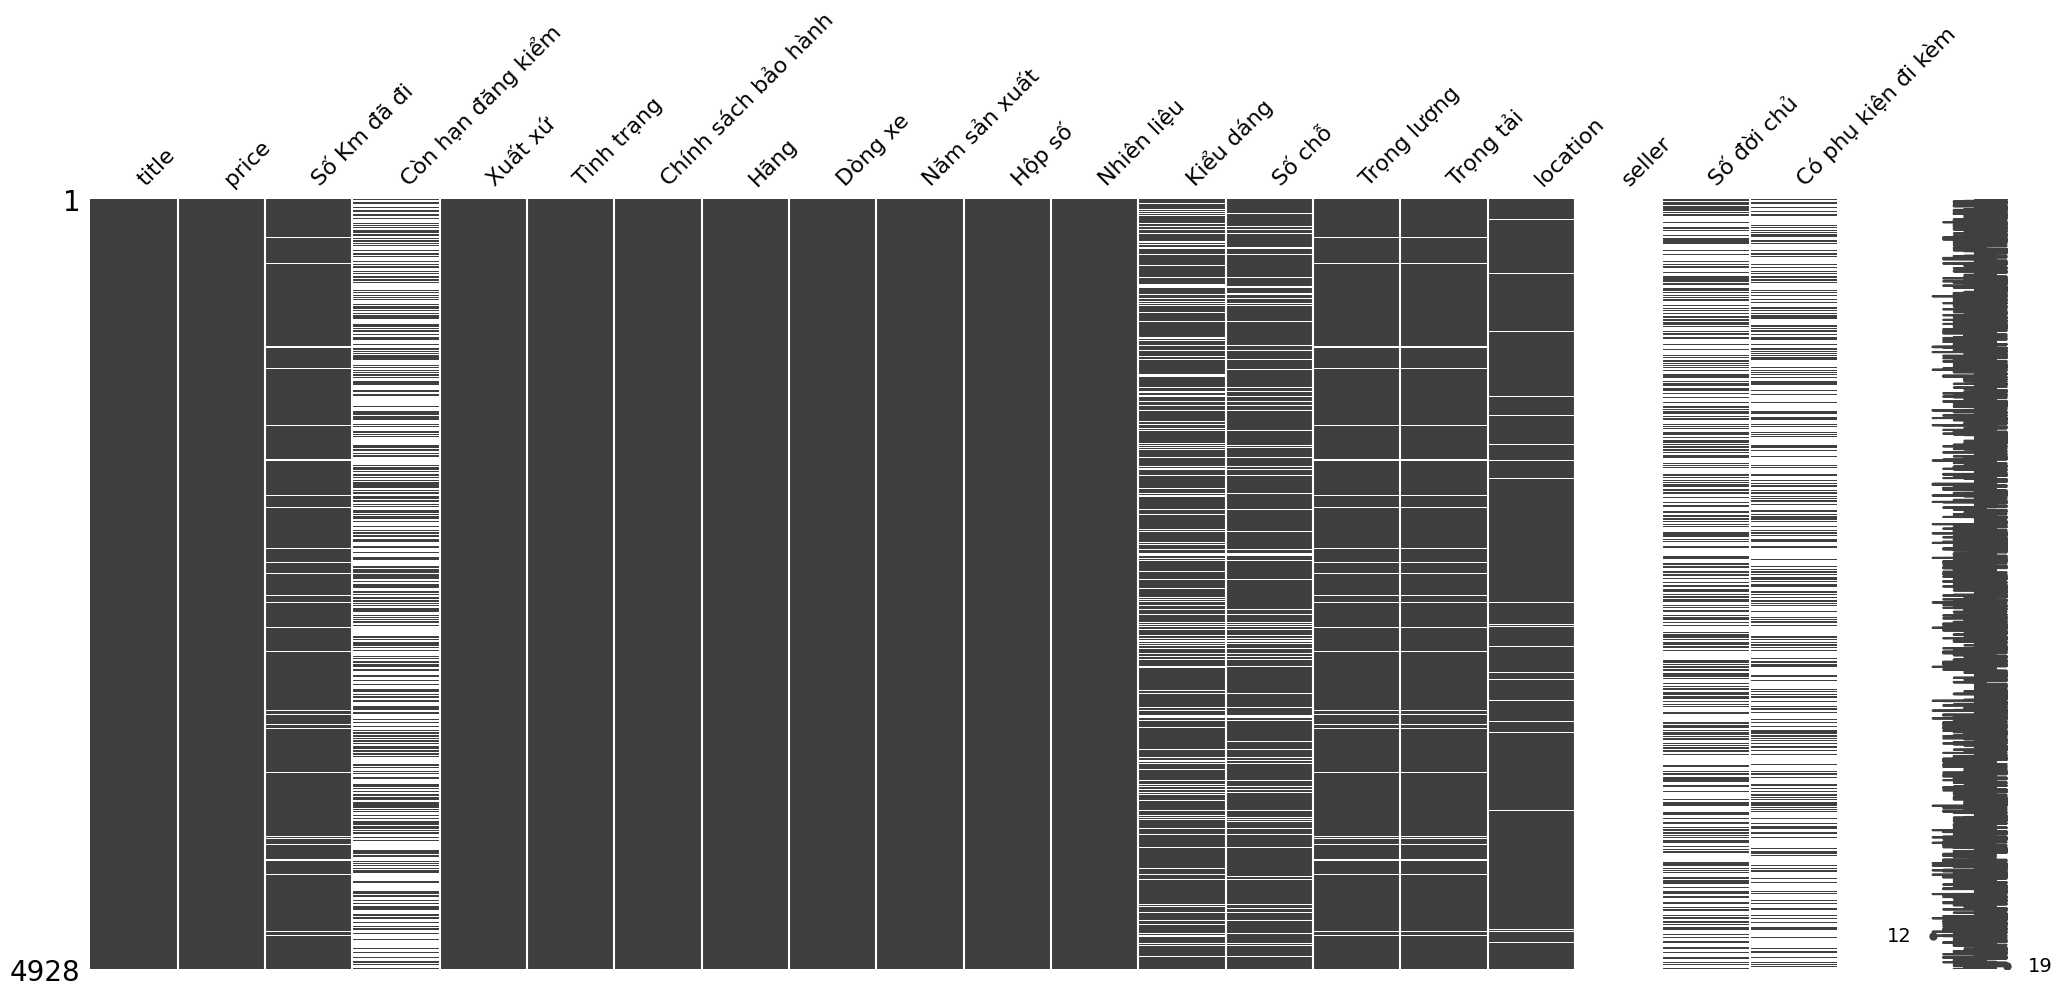

In [5]:
msno.matrix(df_chotot)

In [6]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

In [7]:
chotot_missing_summary = get_numerical_summary(df_chotot)

Số Km đã đi : 213 (4.322%)
Còn hạn đăng kiểm : 2872 (58.279%)
Kiểu dáng : 840 (17.045%)
Số chỗ : 548 (11.12%)
Trọng lượng : 213 (4.322%)
Trọng tải : 213 (4.322%)
location : 149 (3.024%)
seller : 4928 (100.0%)
Số đời chủ : 2808 (56.981%)
Có phụ kiện đi kèm : 3332 (67.614%)


**Phân loại theo tỷ lệ missing:**

| Cột | Missing | Quyết định |
|-----|---------|------------|
| `Số Km đã đi` | 4.3% | GIỮ - impute median |
| `Kiểu dáng` | 17.0% | GIỮ - impute theo brand+model |
| `Số chỗ` | 11.1% | GIỮ - impute theo body_type |
| `location` | 3.0% | GIỮ - fill "Khac" |
| `Trọng lượng`, `Trọng tải` | 4.3% | BỎ - ít liên quan |
| `Còn hạn đăng kiểm` | 58.3% | BỎ - missing quá nhiều |
| `Số đời chủ` | 57.0% | BỎ - missing quá nhiều |
| `Có phụ kiện đi kèm` | 67.6% | BỎ - missing quá nhiều |
| `seller` | 100% | BỎ - hoàn toàn trống |

#### BonBanh

In [8]:
df_bonbanh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           10000 non-null  object
 1   price           10000 non-null  object
 2   location        9985 non-null   object
 3   Tình trạng      10000 non-null  object
 4   Năm sản xuất    10000 non-null  object
 5   Xuất xứ         10000 non-null  object
 6   Động cơ         10000 non-null  object
 7   Kiểu dáng       10000 non-null  object
 8   Hộp số          10000 non-null  object
 9   Số Km đã đi     10000 non-null  object
 10  Dẫn động        10000 non-null  object
 11  Màu ngoại thất  10000 non-null  object
 12  Màu nội thất    10000 non-null  object
 13  Số cửa          10000 non-null  object
 14  Số chỗ ngồi     10000 non-null  object
dtypes: object(15)
memory usage: 1.1+ MB


- Dataset có 10,000 samples, 15 features - tất cả đều đang ở định dạng `object` (string)
- Dữ liệu BonBanh có vẻ sạch hơn Chotot về mặt số lượng missing values
- Cần chuyển các cột về đúng định dạng `numerical/categorical`

In [9]:
df_bonbanh.head()

,title,price,location,Tình trạng,Năm sản xuất,Xuất xứ,Động cơ,Kiểu dáng,Hộp số,Số Km đã đi,Dẫn động,Màu ngoại thất,Màu nội thất,Số cửa,Số chỗ ngồi
0,Xe Mercedes Benz C class C300 AMG\t2022,1 Tỷ 679 Triệu,Quận 7 TP HCM,Xe đã dùng,2022,Nhập khẩu,Xăng 2.0 L,Sedan,Số tự động,"6,900 Km",RFD - Dẫn động cầu sau,Trắng,Nhiều màu,4 cửa,5 chỗ
1,Xe VinFast VF3 Plus\t2025,267 Triệu,"314 Lũy Bán Bích, Hòa Thạnh, Tân Phú TP HCM",Xe đã dùng,2025,Trong nước,Điện,Hatchback,Số tự động,"18,000 Km",RFD - Dẫn động cầu sau,Đỏ,Đen,3 cửa,4 chỗ
2,Xe Honda Civic E 1.8 AT\t2019,498 Triệu,"314 Lũy Bán Bích, Hòa Thạnh, Tân Phú TP HCM",Xe đã dùng,2019,Nhập khẩu,Xăng 1.8 L,Sedan,Số tự động,"28,000 Km",FWD - Dẫn động cầu trước,Bạc,Đen,4 cửa,5 chỗ
3,Xe Mercedes Benz GLB 35 4Matic\t2021,1 Tỷ 450 Triệu,Quận 7 TP HCM,Xe đã dùng,2021,Nhập khẩu,Xăng 2.0 L,SUV,Số tự động,"52,000 Km",AWD - 4 bánh toàn thời gian,Trắng,Đen,5 cửa,7 chỗ
4,Xe Ford Explorer Limited 2.3L EcoBoost\t2021,1 Tỷ 650 Triệu,"900 Quốc lộ 1A, Phường Thạnh Xuân, Quận 12 TP HCM",Xe đã dùng,2021,Nhập khẩu,Xăng 2.3 L,SUV,Số tự động,"80,000 Km",AWD - 4 bánh toàn thời gian,Xanh,Đen,5 cửa,7 chỗ


**Nhận xét các cột sẽ GIỮ LẠI:**

- `title`: Chứa hãng/tên xe/phiên bản/năm. Cần extract `brand` và `model`.

- `price`: Format `1 Tỷ 679 Triệu`, `498 Triệu`. Parse: `Tỷ` = 1000, `Triệu` = 1.

- `location`: Địa chỉ chi tiết, cần extract tỉnh/thành phố.

- `Tình trạng`: `Xe đã dùng`/`Xe mới` - binary.

- `Xuất xứ`: `Nhập khẩu`/`Trong nước` - binary.

- `Động cơ`: Chứa nhiên liệu và dung tích (ví dụ: `Xăng 2.0 L`). Chỉ extract `fuel_type`.

- `Kiểu dáng`: Sedan, SUV, Hatchback, etc.

- `Hộp số`: `Số tự động`/`Số tay`.

- `Số Km đã đi`: Format `6,900 Km`, xe mới có `-`. Parse về numeric.

- `Số chỗ ngồi`: Format `5 chỗ`, `7 chỗ`. Extract số.

**Các cột sẽ BỎ (không có ở Chotot hoặc ít quan trọng):**
- `Dẫn động`: Không có ở Chotot, khó fill chính xác
- `Màu ngoại thất`, `Màu nội thất`: Ít ảnh hưởng giá
- `Số cửa`: Không có ở Chotot, ít quan trọng
- `Dung tích` (từ Động cơ): Không có ở Chotot, khó fill chính xác

<Axes: >

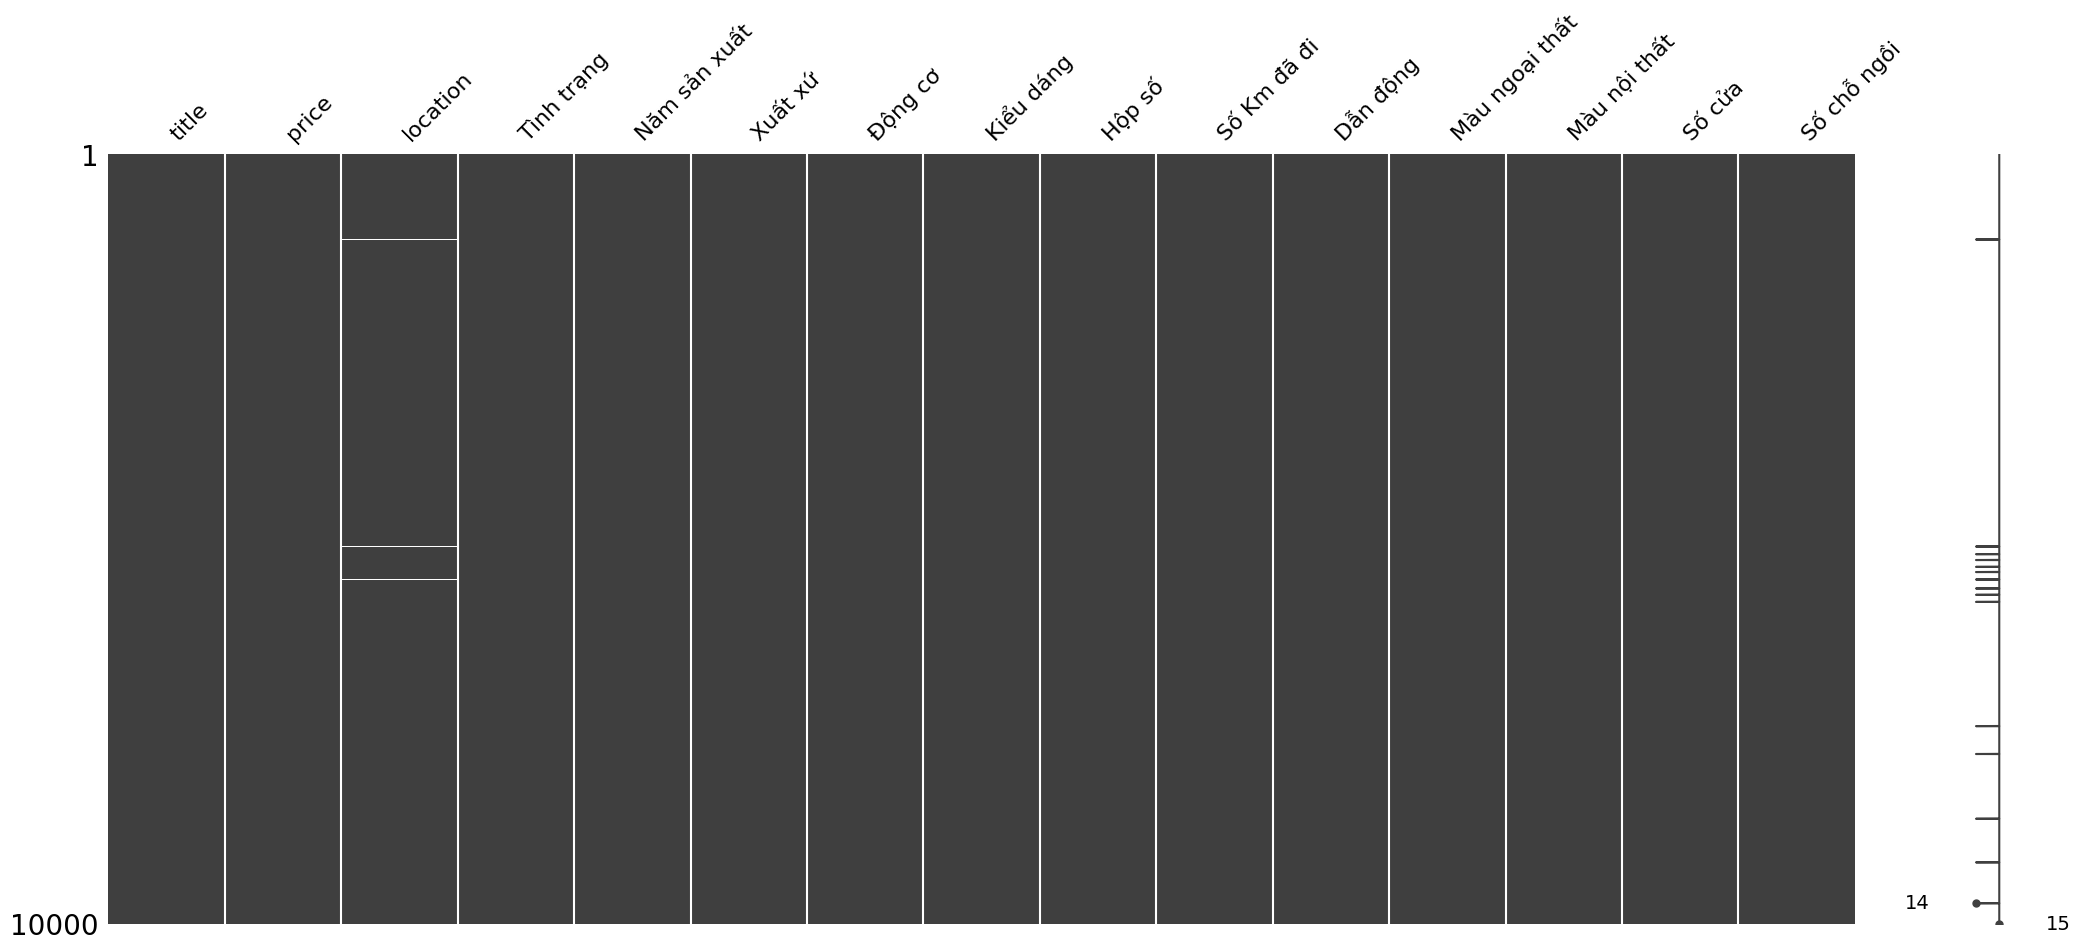

In [10]:
msno.matrix(df_bonbanh)

In [11]:
bonbanh_missing_summary = get_numerical_summary(df_bonbanh)

location : 15 (0.15%)


Dataset BonBanh có chất lượng rất cao với hầu như không có missing values:
- Chỉ có cột `location` có 15 giá trị thiếu (0.15%) - tỷ lệ cực thấp, có thể bỏ qua hoặc dễ dàng xử lý.
- Tất cả các feature khác đều đầy đủ 100% dữ liệu.

### Tổng hợp kế hoạch xử lý


**Mục tiêu:** Dự đoán giá xe (regression) với độ chính xác cao nhất. Target: `price_million`

#### Quyết định về features

| Cột             | Chotot                  | BonBanh             | Xử lý                        |
|-----------------|-------------------------|---------------------|------------------------------|
| `brand`         | Hãng                    | Extract từ title    | Chuẩn hóa tên hãng           |
| `model`         | Dòng xe                 | Extract từ title    | Chuẩn hóa tên model          |
| `price_million` | Parse từ price          | Parse từ price      | Target variable              |
| `year`          | Năm sản xuất            | Năm sản xuất        | Convert int                  |
| `km`            | Số Km đã đi             | Số Km đã đi         | Parse, handle placeholders   |
| `transmission`  | Hộp số                  | Hộp số              | Chuẩn hóa: AT/MT             |
| `fuel_type`     | Nhiên liệu              | Tách từ Động cơ     | Chuẩn hóa categories         |
| `body_type`     | Kiểu dáng               | Kiểu dáng           | Impute theo brand+model      |
| `seats`         | Số chỗ                  | Số chỗ ngồi         | Impute theo body_type        |
| `origin`        | Xuất xứ                 | Xuất xứ             | Binary: Nhập khẩu/Trong nước |
| `condition`     | Tình trạng              | Tình trạng          | Binary: Mới/Đã dùng          |
| `city`          | Parse từ location       | Parse từ location   | Fill "unknow" nếu thiếu      |
| `engine`        | Tạo thêm missing_engine | Parse từ nhiên liệu | Fill "unknow" nếu thiếu      |

#### Các cột sẽ BỎ

**Chotot:**
- `seller` (100% missing)
- `Còn hạn đăng kiểm` (58% missing)
- `Số đời chủ` (57% missing)
- `Có phụ kiện đi kèm` (68% missing)
- `Chính sách bảo hành` (không ảnh hưởng giá)
- `Trọng lượng`, `Trọng tải` (ít liên quan)

**BonBanh:**
- `Màu ngoại thất`, `Màu nội thất` (ít ảnh hưởng giá, phức tạp)
- `engine_capacity` (không có ở Chotot, khó fill chính xác)
- `drivetrain` (không có ở Chotot, khó fill chính xác)
- `doors` (không có ở Chotot, ít quan trọng)

### II. Chuẩn hóa dữ liệu

#### 2.1 Parse price

In [12]:
def parse_chotot_price(price_str):
    """Parse Chotot price: '320.000.000 đ' -> 320"""
    if pd.isna(price_str):
        return np.nan
    nums = re.sub(r'[^\d]', '', str(price_str))
    return int(nums) / 1_000_000 if nums else np.nan

def parse_bonbanh_price(price_str):
    """Parse BonBanh price: '1 Tỷ 679 Triệu' -> 1679"""
    if pd.isna(price_str):
        return np.nan
    s = str(price_str)
    ty = re.search(r'(\d+)\s*Tỷ', s)
    trieu = re.search(r'(\d+)\s*Triệu', s)
    total = 0
    if ty:
        total += int(ty.group(1)) * 1000
    if trieu:
        total += int(trieu.group(1))
    return total if total > 0 else np.nan

df_chotot['price_million'] = df_chotot['price'].apply(parse_chotot_price)
df_bonbanh['price_million'] = df_bonbanh['price'].apply(parse_bonbanh_price)

In [13]:
df_chotot[['price', 'price_million']].head(10)

,price,price_million
0,320.000.000 đ,320.0
1,108.000.000 đ,108.0
2,365.000.000 đ,365.0
3,339.000.000 đ,339.0
4,380.000.000 đ,380.0
5,2.450.000.000 đ,2450.0
6,170.000.000 đ,170.0
7,740.000.000 đ,740.0
8,450.000.000 đ,450.0
9,790.000.000 đ,790.0


In [14]:
df_bonbanh[['price', 'price_million']].head(10)

,price,price_million
0,1 Tỷ 679 Triệu,1679
1,267 Triệu,267
2,498 Triệu,498
3,1 Tỷ 450 Triệu,1450
4,1 Tỷ 650 Triệu,1650
5,3 Tỷ 899 Triệu,3899
6,8 Tỷ 999 Triệu,8999
7,2 Tỷ 79 Triệu,2079
8,3 Tỷ 179 Triệu,3179
9,899 Triệu,899


#### 2.2 Xử lý số km đã đi

In [15]:
# Chotot: đã là numeric, chỉ cần xử lý placeholder (999999)
df_chotot['km'] = df_chotot['Số Km đã đi'].apply(
    lambda x: np.nan if pd.isna(x) or x >= 900000 else x
)

# BonBanh: parse string format '6,900 Km', '-' = xe mới
def parse_bonbanh_km(km_str):
    """Chuyển đổi chuỗi km BonBanh về số"""
    if pd.isna(km_str):
        return np.nan
    s = str(km_str).strip()
    if s == '-':
        return 0  # Xe mới chưa đi
    nums = re.sub(r'[^\d]', '', s)
    return int(nums) if nums else np.nan

df_bonbanh['km'] = df_bonbanh['Số Km đã đi'].apply(parse_bonbanh_km)

print("Chotot km:", df_chotot['km'].describe())
print("\nBonBanh km:", df_bonbanh['km'].describe())

Chotot km: count      4686.000000
mean      97635.938327
std      106431.581556
min           0.000000
25%       30000.000000
50%       80000.000000
75%      125000.000000
max      896000.000000
Name: km, dtype: float64

BonBanh km: count    1.000000e+04
mean     4.289276e+04
std      5.762645e+04
min      0.000000e+00
25%      0.000000e+00
50%      3.200000e+04
75%      6.900000e+04
max      2.000000e+06
Name: km, dtype: float64


#### 2.3 Xử lý năm sản xuất

In [16]:
CURRENT_YEAR = 2025

def parse_year(year_val):
    """Chuyển đổi năm sản xuất về int, validate range hợp lệ"""
    if pd.isna(year_val):
        return np.nan
    try:
        y = int(float(year_val))
        return y if 1980 <= y <= CURRENT_YEAR + 1 else np.nan
    except:
        return np.nan

df_chotot['year'] = df_chotot['Năm sản xuất'].apply(parse_year)
df_bonbanh['year'] = df_bonbanh['Năm sản xuất'].apply(parse_year)

print("Chotot - năm sản xuất:", df_chotot['year'].min(), "-", df_chotot['year'].max())
print("BonBanh - năm sản xuất:", df_bonbanh['year'].min(), "-", df_bonbanh['year'].max())

Chotot - năm sản xuất: 1985.0 - 2025.0
BonBanh - năm sản xuất: 1992.0 - 2025.0


#### 2.4 Chuẩn hóa hãng xe và dòng xe

In [17]:
# Chotot đã có sẵn cột Hãng và Dòng xe
df_chotot['brand'] = df_chotot['Hãng'].str.strip()
df_chotot['model'] = df_chotot['Dòng xe'].str.strip()

# BonBanh: cần extract từ title (format: "Xe [Brand] [Model] [Variant]\t[Year]")
df_bonbanh['title'].head(10)

0          Xe Mercedes Benz C class C300 AMG\t2022
1                        Xe VinFast VF3 Plus\t2025
2                    Xe Honda Civic E 1.8 AT\t2019
3             Xe Mercedes Benz GLB 35 4Matic\t2021
4     Xe Ford Explorer Limited 2.3L EcoBoost\t2021
5       Xe Mercedes Benz S class S450 Luxury\t2021
6                           Xe Lexus LM 500h\t2025
7    Xe Mercedes Benz C class C43 AMG 4Matic\t2023
8                       Xe Porsche Macan 2.0\t2022
9                Xe Audi A4 40 TFSI Advanced\t2019
Name: title, dtype: object

In [18]:
# Danh sách các hãng xe (bao gồm các biến thể viết liền/cách)
CAR_BRANDS = [
    # Luxury
    'Mercedes Benz', 'BMW', 'Audi', 'Lexus', 'Porsche', 
    'Land Rover', 'LandRover', 'Jaguar', 'Volvo', 'Mini', 
    'Bentley', 'Rolls Royce', 'Maserati', 'Ferrari', 'Lamborghini',
    # Japanese
    'Toyota', 'Honda', 'Mazda', 'Mitsubishi', 'Nissan', 'Suzuki', 'Subaru', 'Isuzu',
    # Korean
    'Hyundai', 'Kia', 'Genesis', 'SsangYong', 'Daewoo',
    # American
    'Ford', 'Chevrolet', 'Jeep', 'Dodge', 'Cadillac', 'Lincoln', 'GMC',
    # European
    'Peugeot', 'Renault', 'Citroen', 'Fiat', 'Alfa Romeo', 'Skoda', 'Seat', 'Volkswagen',
    # Chinese/Vietnamese
    'VinFast', 'MG', 'Haval', 'Wuling', 'BYD', 'Chery', 'Geely', 'Omoda',
    'Haima', 'Zotye', 'BAIC', 'Dongfeng', 'JAC', 'Great Wall', 'Bestune', 'Gaz'
]

# Sắp xếp brand theo độ dài giảm dần để match chính xác hơn
CAR_BRANDS = sorted(CAR_BRANDS, key=len, reverse=True)

# Các từ khóa hộp số trong title
TRANSMISSIONS_IN_TITLE = ['AT', 'MT', 'CVT', 'DCT', 'AMT']

# Các từ khóa dẫn động trong title
DRIVES_IN_TITLE = ['4x2', '4x4', '2WD', '4WD', 'AWD', 'FWD', 'RWD', 'HTRAC', '4Matic', 'xDrive', 'Quattro']

# Regex cho động cơ: 2.0L, 3.5 V6, 2.0 Turbo, etc. (phải có L hoặc khoảng trắng + chữ cái sau số)
ENGINE_PATTERN = r'\b\d+\.\d+\s*[Ll]\b|\b\d+\.\d+\s+[VvIi]+\d*\b|\b\d+\.\d+\s+Turbo\b'

def extract_brand_model(title):
    """
    Trích xuất brand và model từ title BonBanh.
    Ý tưởng: Loại bỏ dần các thành phần đã biết, phần còn lại là model.
    """
    if pd.isna(title):
        return None, None

    # Tách phần trước tab (bỏ năm sản xuất)
    parts = str(title).split('\t')
    text = parts[0].strip()

    # Bỏ từ "Xe" ở đầu
    if text.lower().startswith('xe '):
        text = text[3:].strip()

    remaining = text

    # --- 1. Tìm và tách brand ---
    brand = None
    for b in CAR_BRANDS:
        if remaining.lower().startswith(b.lower()):
            brand = b
            remaining = remaining[len(b):].strip()
            break

    # Nếu không tìm thấy brand trong list, lấy từ đầu tiên
    if brand is None and remaining:
        words = remaining.split()
        brand = words[0]
        remaining = ' '.join(words[1:])

    # --- 2. Loại bỏ các thành phần không phải model ---

    # Loại bỏ transmission keywords (chỉ khi đứng riêng, không phải phần của từ khác)
    for t in TRANSMISSIONS_IN_TITLE:
        remaining = re.sub(r'\b' + re.escape(t) + r'\b(?!\w)', '', remaining)

    # Loại bỏ drive keywords
    for d in DRIVES_IN_TITLE:
        remaining = re.sub(r'\b' + re.escape(d) + r'\b', '', remaining, flags=re.IGNORECASE)

    # Loại bỏ engine pattern rõ ràng (2.0L, 3.5 V6, etc.)
    remaining = re.sub(ENGINE_PATTERN, '', remaining)

    # Loại bỏ số thập phân đứng riêng (dung tích động cơ như 2.0, 3.5)
    remaining = re.sub(r'\b\d+\.\d+\b(?!\w)', '', remaining)

    # Dọn dẹp khoảng trắng thừa
    remaining = ' '.join(remaining.split())

    # --- 3. Phần còn lại là model ---
    model = remaining.strip() if remaining.strip() else None

    return brand, model

# Apply hàm mới
brand_model = df_bonbanh['title'].apply(extract_brand_model)
df_bonbanh['brand'] = brand_model.apply(lambda x: x[0])
df_bonbanh['model'] = brand_model.apply(lambda x: x[1])

In [19]:
df_bonbanh[['brand','model']].head(20)

,brand,model
0,Mercedes Benz,C class C300 AMG
1,VinFast,VF3 Plus
2,Honda,Civic E
3,Mercedes Benz,GLB 35
4,Ford,Explorer Limited EcoBoost
5,Mercedes Benz,S class S450 Luxury
6,Lexus,LM 500h
7,Mercedes Benz,C class C43 AMG
8,Porsche,Macan
9,Audi,A4 40 TFSI Advanced


#### 2.5 Extract engine từ nhiên liệu

In [20]:
df_chotot['engine'] = 0                 # tất cả đều 0
df_chotot['engine_missing'] = 1         # tất cả đều missing

In [21]:
# ---- Hàm trích xuất engine từ cột 'Động cơ' Bonbanh ----
def extract_engine(engine_text):
    """
    Trích xuất engine_displacement từ cột 'Động cơ' Bonbanh
    Ví dụ: 'Xăng 2.0 L', 'Dầu 2.4L', 'Hybrid 1.5 L'
    Trả về float: 2.0, 2.4, 1.5
    """
    if pd.isna(engine_text):
        return np.nan
    match = re.search(r"(\d+(\.\d+)?)\s*[lL]", engine_text)
    if match:
        return float(match.group(1))
    return np.nan

# Engine từ cột 'Động cơ'
df_bonbanh['engine'] = df_bonbanh['Động cơ'].apply(extract_engine)
df_bonbanh['engine'] = df_bonbanh['engine'].fillna(0)

# Tạo cột engine_missing
df_bonbanh['engine_missing'] = (df_bonbanh['engine'] == 0).astype(int)

#### 2.6 Chuẩn hóa các biến categorical

In [22]:
df_bonbanh[['engine']].head(20)

,engine
0,2.0
1,0.0
2,1.8
3,2.0
4,2.3
5,3.0
6,2.4
7,2.0
8,2.0
9,2.0


In [23]:
# Hộp số: AT (tự động) / MT (số sàn)
trans_map_chotot = {'Tự động': 'AT', 'Số sàn': 'MT', 'Bán tự động': 'AT'}
trans_map_bonbanh = {'Số tự động': 'AT', 'Số tay': 'MT'}

df_chotot['transmission'] = df_chotot['Hộp số'].map(trans_map_chotot)
df_bonbanh['transmission'] = df_bonbanh['Hộp số'].map(trans_map_bonbanh)

# Nhiên liệu
fuel_map = {'Động cơ Hybrid': 'Hybrid'}
df_chotot['fuel_type'] = df_chotot['Nhiên liệu'].replace(fuel_map)
df_bonbanh['fuel_type'] = df_bonbanh['Động cơ'].str.extract(r'^(Xăng|Dầu|Điện|Hybrid)', expand=False)

# Kiểu dáng - giữ nguyên, sẽ impute sau
df_chotot['body_type'] = df_chotot['Kiểu dáng']
df_bonbanh['body_type'] = df_bonbanh['Kiểu dáng']

# Xuất xứ: Chotot là tên quốc gia -> chuyển về binary
df_chotot['origin'] = df_chotot['Xuất xứ'].apply(
    lambda x: 'Trong nước' if x == 'Việt Nam' else 'Nhập khẩu' if pd.notna(x) and x != 'Đang cập nhật' else np.nan
)
df_bonbanh['origin'] = df_bonbanh['Xuất xứ'].map({'Nhập khẩu': 'Nhập khẩu', 'Trong nước': 'Trong nước'})

# Tình trạng: binary
df_chotot['condition'] = df_chotot['Tình trạng'].map({'Đã sử dụng': 'Cũ', 'Mới': 'Mới'})
df_bonbanh['condition'] = df_bonbanh['Tình trạng'].map({'Xe đã dùng': 'Cũ', 'Xe mới': 'Mới'})

print("Hộp số:", df_chotot['transmission'].value_counts().to_dict())
print("Nhiên liệu:", df_chotot['fuel_type'].value_counts().to_dict())
print("Xuất xứ:", df_chotot['origin'].value_counts().to_dict())
print("Tình trạng:", df_chotot['condition'].value_counts().to_dict())

Hộp số: {'AT': 3254, 'MT': 1656}
Nhiên liệu: {'Xăng': 3997, 'Dầu': 687, 'Điện': 211, 'Hybrid': 33}
Xuất xứ: {'Trong nước': 1989, 'Nhập khẩu': 1844}
Tình trạng: {'Cũ': 4715, 'Mới': 213}


#### 2.7 Xử lý số chỗ ngồi

In [24]:
# Trích xuất số từ chuỗi: '5 chỗ' -> 5
def parse_seats(val):
    """Trích xuất số chỗ ngồi từ chuỗi"""
    if pd.isna(val):
        return np.nan
    nums = re.search(r'(\d+)', str(val))
    return int(nums.group(1)) if nums else np.nan

df_chotot['seats'] = df_chotot['Số chỗ'].apply(parse_seats)
df_bonbanh['seats'] = df_bonbanh['Số chỗ ngồi'].apply(parse_seats)

print("Chotot - số chỗ:", df_chotot['seats'].value_counts().head().to_dict())
print("BonBanh - số chỗ:", df_bonbanh['seats'].value_counts().head().to_dict())

Chotot - số chỗ: {5.0: 2328, 7.0: 935, 8.0: 311, 4.0: 170, 2.0: 99}
BonBanh - số chỗ: {5: 6442, 7: 2671, 4: 363, 8: 200, 6: 113}


#### 2.8 Trích xuất thành phố từ địa chỉ

In [25]:
# Danh sách thành phố/tỉnh
CITIES = [
    'TP HCM', 'Hồ Chí Minh', 'HCM', 'Hà Nội', 'Đà Nẵng', 'Hải Phòng', 'Cần Thơ',
    'Bình Dương', 'Đồng Nai', 'Khánh Hòa', 'Bà Rịa', 'Long An', 'Bắc Ninh',
    'Thanh Hóa', 'Nghệ An', 'Hải Dương', 'Quảng Ninh', 'Nam Định', 'Thái Nguyên',
    'Vĩnh Phúc', 'Phú Thọ', 'Bắc Giang', 'Hưng Yên', 'Thái Bình', 'Lâm Đồng',
    'Kiên Giang', 'An Giang', 'Đắk Lắk', 'Bình Thuận', 'Bình Định', 'Quảng Nam',
    'Ninh Bình', 'Tiền Giang', 'Đồng Tháp', 'Vĩnh Long', 'Tây Ninh', 'Sóc Trăng',
    'Bến Tre', 'Trà Vinh', 'Cà Mau', 'Bạc Liêu', 'Hậu Giang', 'Phú Yên', 'Gia Lai',
    'Kon Tum', 'Đắk Nông', 'Quảng Ngãi', 'Quảng Bình', 'Quảng Trị', 'Thừa Thiên Huế',
    'Hà Tĩnh', 'Sơn La', 'Hòa Bình', 'Lào Cai', 'Yên Bái', 'Điện Biên', 'Lai Châu',
    'Lạng Sơn', 'Cao Bằng', 'Hà Giang', 'Tuyên Quang', 'Bắc Kạn'
]

def extract_city(location):
    """Trích xuất tên thành phố từ địa chỉ"""
    if pd.isna(location):
        return 'Khác'
    loc = str(location)
    # Chuẩn hóa HCM và Hà Nội
    if 'HCM' in loc or 'Hồ Chí Minh' in loc or 'HCM' in loc:
        return 'Hồ Chí Minh'
    if 'Hà Nội' in loc:
        return 'Hà Nội'
    # Tìm trong danh sách
    for city in CITIES:
        if city in loc:
            return city
    return 'unknow'

df_chotot['city'] = df_chotot['location'].apply(extract_city)
df_bonbanh['city'] = df_bonbanh['location'].apply(extract_city)

print("Top thành phố Chotot:", df_chotot['city'].value_counts().head(10).to_dict())
print("Top thành phố BonBanh:", df_bonbanh['city'].value_counts().head(10).to_dict())

Top thành phố Chotot: {'Hồ Chí Minh': 1791, 'Hà Nội': 783, 'Đà Nẵng': 284, 'Bình Dương': 260, 'Đồng Nai': 251, 'Đắk Lắk': 156, 'Khác': 149, 'Cần Thơ': 125, 'Bà Rịa': 93, 'Lâm Đồng': 71}
Top thành phố BonBanh: {'Hà Nội': 6500, 'Hồ Chí Minh': 2075, 'Hải Phòng': 263, 'Bình Dương': 155, 'Phú Thọ': 86, 'unknow': 85, 'Vĩnh Phúc': 81, 'Bắc Ninh': 58, 'Đà Nẵng': 58, 'Quảng Ninh': 55}


#### Chuẩn hóa dtype giữa 2 datasets

In [26]:
# Pandas tự động convert int -> float khi có NaN, nên cần thống nhất dtype

# price_million: giữ float (vì có thể có giá trị thập phân)
df_chotot['price_million'] = df_chotot['price_million'].astype('float64')
df_bonbanh['price_million'] = df_bonbanh['price_million'].astype('float64')

# km: giữ float (vì Chotot có NaN)
df_chotot['km'] = df_chotot['km'].astype('float64')
df_bonbanh['km'] = df_bonbanh['km'].astype('float64')

# year: giữ float (vì có NaN)
df_chotot['year'] = df_chotot['year'].astype('float64')
df_bonbanh['year'] = df_bonbanh['year'].astype('float64')

# seats: giữ float (vì Chotot có NaN)
df_chotot['seats'] = df_chotot['seats'].astype('float64')
df_bonbanh['seats'] = df_bonbanh['seats'].astype('float64')

#### 2.9 Tổng kết Phase II
Các cột đã chuẩn hóa

In [27]:
STANDARDIZED_COLS = ['price_million', 'km', 'year', 'brand', 'model', 'transmission', 'fuel_type',
                     'body_type', 'origin', 'condition', 'seats', 'city', 'engine', 'engine_missing']

Chotot

In [28]:
df_chotot[STANDARDIZED_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4928 entries, 0 to 4927
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_million   4928 non-null   float64
 1   km              4686 non-null   float64
 2   year            4917 non-null   float64
 3   brand           4928 non-null   object 
 4   model           4928 non-null   object 
 5   transmission    4910 non-null   object 
 6   fuel_type       4928 non-null   object 
 7   body_type       4088 non-null   object 
 8   origin          3833 non-null   object 
 9   condition       4928 non-null   object 
 10  seats           4000 non-null   float64
 11  city            4928 non-null   object 
 12  engine          4928 non-null   int64  
 13  engine_missing  4928 non-null   int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 539.1+ KB


In [29]:
df_chotot[STANDARDIZED_COLS].head()

,price_million,km,year,brand,model,transmission,fuel_type,body_type,origin,condition,seats,city,engine,engine_missing
0,320.0,88000.0,2007.0,BMW,X5,AT,Xăng,SUV / Cross over,NaN,Cũ,8.0,Hồ Chí Minh,0,1
1,108.0,135000.0,2001.0,Mercedes Benz,E Class,AT,Xăng,Sedan,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,0,1
2,365.0,275000.0,2017.0,Ford,Transit,MT,Dầu,Kiểu dáng khác,Trong nước,Cũ,16.0,Cần Thơ,0,1
3,339.0,60150.0,2016.0,Chevrolet,Cruze,AT,Xăng,Sedan,Nhập khẩu,Cũ,5.0,Cần Thơ,0,1
4,380.0,15000.0,2009.0,Toyota,Camry,AT,Xăng,Sedan,Nhập khẩu,Cũ,4.0,Hà Nội,0,1


BonBanh

In [30]:
df_bonbanh[STANDARDIZED_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_million   10000 non-null  float64
 1   km              10000 non-null  float64
 2   year            9999 non-null   float64
 3   brand           10000 non-null  object 
 4   model           10000 non-null  object 
 5   transmission    10000 non-null  object 
 6   fuel_type       10000 non-null  object 
 7   body_type       10000 non-null  object 
 8   origin          10000 non-null  object 
 9   condition       10000 non-null  object 
 10  seats           10000 non-null  float64
 11  city            10000 non-null  object 
 12  engine          10000 non-null  float64
 13  engine_missing  10000 non-null  int64  
dtypes: float64(5), int64(1), object(8)
memory usage: 1.1+ MB


In [31]:
df_bonbanh[STANDARDIZED_COLS].head()

,price_million,km,year,brand,model,transmission,fuel_type,body_type,origin,condition,seats,city,engine,engine_missing
0,1679.0,6900.0,2022.0,Mercedes Benz,C class C300 AMG,AT,Xăng,Sedan,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,2.0,0
1,267.0,18000.0,2025.0,VinFast,VF3 Plus,AT,Điện,Hatchback,Trong nước,Cũ,4.0,Hồ Chí Minh,0.0,1
2,498.0,28000.0,2019.0,Honda,Civic E,AT,Xăng,Sedan,Nhập khẩu,Cũ,5.0,Hồ Chí Minh,1.8,0
3,1450.0,52000.0,2021.0,Mercedes Benz,GLB 35,AT,Xăng,SUV,Nhập khẩu,Cũ,7.0,Hồ Chí Minh,2.0,0
4,1650.0,80000.0,2021.0,Ford,Explorer Limited EcoBoost,AT,Xăng,SUV,Nhập khẩu,Cũ,7.0,Hồ Chí Minh,2.3,0


#### 2.10 Merge Datasets

Sau khi chuẩn hóa xong, merge 2 datasets thành 1 để xử lý thống nhất từ đây về sau.

In [32]:
# Merge 2 datasets với cột source để trace nguồn gốc
df = pd.concat([
    df_chotot[STANDARDIZED_COLS].assign(source='chotot'),
    df_bonbanh[STANDARDIZED_COLS].assign(source='bonbanh')
], ignore_index=True)

# Tạo thư mục nếu chưa tồn tại
os.makedirs('../data/interim', exist_ok=True)
df.to_csv('../data/interim/normalize_interim.csv', index=False, encoding='utf-8-sig')

print(f"Merged dataset: {len(df)} rows")
print(f"  - Chotot: {len(df[df['source'] == 'chotot'])} rows")
print(f"  - BonBanh: {len(df[df['source'] == 'bonbanh'])} rows")
print(f"\nCác cột: {list(df.columns)}")
df.info()

Merged dataset: 14928 rows
  - Chotot: 4928 rows
  - BonBanh: 10000 rows

Các cột: ['price_million', 'km', 'year', 'brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'seats', 'city', 'engine', 'engine_missing', 'source']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14928 entries, 0 to 14927
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_million   14928 non-null  float64
 1   km              14686 non-null  float64
 2   year            14916 non-null  float64
 3   brand           14928 non-null  object 
 4   model           14928 non-null  object 
 5   transmission    14910 non-null  object 
 6   fuel_type       14928 non-null  object 
 7   body_type       14088 non-null  object 
 8   origin          13833 non-null  object 
 9   condition       14928 non-null  object 
 10  seats           14000 non-null  float64
 11  city            14928 non-null  object 
 12  eng

### III. Xử lý Outliers

#### Chiến lược xử lý outliers

**Vấn đề:** Dữ liệu giá xe có phân phối lệch phải (right-skewed) với nhiều xe cao cấp có giá rất cao. Việc xử lý outliers cần cân nhắc:
- Giữ lại các giá trị hợp lệ (xe siêu sang có giá cao là bình thường)
- Loại bỏ các giá trị không hợp lý (lỗi nhập liệu, spam)

**Phương pháp:**
1. **IQR (Interquartile Range):** Phù hợp cho dữ liệu phân phối lệch
2. **Domain knowledge:** Áp dụng ngưỡng thực tế cho thị trường xe Việt Nam

#### 3.1 Khám phá phân phối dữ liệu số

Trước khi xử lý outliers, cần hiểu phân phối của các biến số để chọn phương pháp phù hợp.

In [33]:
# Thống kê mô tả các biến số (trên merged data)
numeric_cols = ['price_million', 'km', 'year']
df[numeric_cols].describe()

,price_million,km,year
count,14928.000000,1.468600e+04,14916.000000
mean,1082.837974,6.036018e+04,2019.049142
std,1730.296609,8.078486e+04,5.945123
min,5.000000,0.000000e+00,1985.000000
25%,379.000000,4.225000e+03,2016.000000
50%,600.000000,4.500000e+04,2021.000000
75%,1080.000000,8.600000e+04,2024.000000
max,63500.000000,2.000000e+06,2025.000000


Visualize phân phối để nhận diện outliers. Sử dụng boxplot và histogram để thấy rõ các giá trị bất thường.

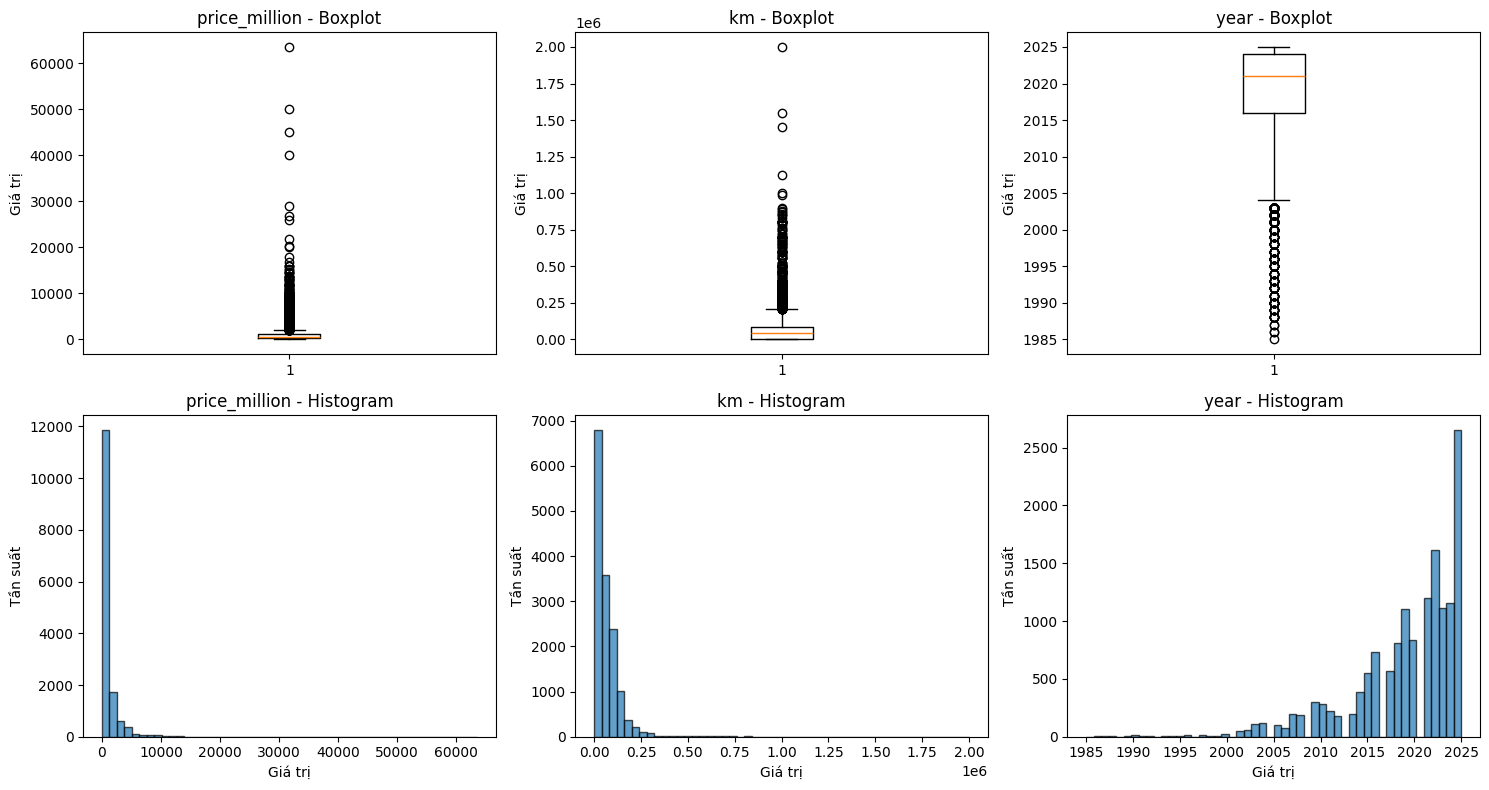

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, col in enumerate(numeric_cols):
    # Boxplot
    axes[0, i].boxplot(df[col].dropna())
    axes[0, i].set_title(f'{col} - Boxplot')
    axes[0, i].set_ylabel('Giá trị')
    
    # Histogram
    axes[1, i].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[1, i].set_title(f'{col} - Histogram')
    axes[1, i].set_xlabel('Giá trị')
    axes[1, i].set_ylabel('Tần suất')

plt.tight_layout()
plt.show()

**Nhận xét từ biểu đồ:**

| Biến | Boxplot | Histogram | Nhận xét |
|------|---------|-----------|----------|
| `price_million` | Nhiều outliers phía trên, giá trị max ~60,000 triệu | Phân phối lệch phải mạnh, tập trung ở mức thấp | Có xe siêu sang giá rất cao + một số lỗi nhập liệu |
| `km` | Outliers rõ rệt > 500k km, max ~2 triệu km | Phân phối lệch phải, đa số xe < 100k km | Các giá trị > 500k km có thể là lỗi |
| `year` | Outliers ở các năm cũ (1985-1995) | Đa số xe từ 2015-2025, ít xe trước 2005 | Dữ liệu tập trung vào xe đời mới, xe quá cũ cần xem xét loại bỏ |

→ Cần loại bỏ các outliers rõ ràng là lỗi nhập liệu, nhưng giữ lại các xe cao cấp có giá hợp lý.

#### 3.2 Xác định ngưỡng outliers bằng IQR

Phương pháp IQR (Interquartile Range):
- Q1 = phân vị 25%, Q3 = phân vị 75%
- IQR = Q3 - Q1
- Lower bound = Q1 - 1.5 × IQR
- Upper bound = Q3 + 1.5 × IQR

Tuy nhiên, với dữ liệu giá xe có phân phối lệch, ta sẽ kết hợp IQR với domain knowledge.

In [35]:
def get_iqr_bounds(series):
    """Tính ngưỡng outliers bằng IQR"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Tính IQR bounds cho từng biến
for col in numeric_cols:
    lower, upper = get_iqr_bounds(df[col].dropna())
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}:")
    print(f"  IQR bounds: [{lower:.2f}, {upper:.2f}]")
    print(f"  Số outliers (IQR): {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    print()

price_million:
  IQR bounds: [-672.50, 2131.50]
  Số outliers (IQR): 1754 (11.75%)

km:
  IQR bounds: [-118437.50, 208662.50]
  Số outliers (IQR): 437 (2.93%)

year:
  IQR bounds: [2004.00, 2036.00]
  Số outliers (IQR): 350 (2.34%)



#### 3.3 Xác định ngưỡng thực tế (Domain Knowledge)

IQR có thể quá nghiêm ngặt với dữ liệu giá xe. Ta kết hợp kiến thức thực tế về thị trường xe Việt Nam:

| Biến | Ngưỡng thấp | Ngưỡng cao | Lý do |
|------|-------------|------------|-------|
| `price_million` | 50 | 15,000 | Xe dưới 50 triệu ít tin cậy, trên 15 tỷ là siêu xe hiếm |
| `km` | 0 | 500,000 | Xe trên 500k km rất hiếm, có thể là lỗi |
| `year` | 1995 | 2025 | Xe quá cũ không có giá trị tham khảo |

In [36]:
# Định nghĩa ngưỡng phát hiện ban đầu (để khảo sát)
OUTLIER_BOUNDS_DETECT = {
    'price_million': (50, 15000),     # 50 triệu - 15 tỷ 
    'km': (0, 500000),                # 0 - 500k km
    'year': (1995, 2025),             # 1995 - 2025
}

# Đếm outliers theo ngưỡng phát hiện
print("Số lượng outliers theo ngưỡng phát hiện:\n")

for col, (lower, upper) in OUTLIER_BOUNDS_DETECT.items():
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col} [{lower}, {upper}]: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")
    
    # Chi tiết theo source
    for source in ['chotot', 'bonbanh']:
        source_outliers = outliers[outliers['source'] == source]
        print(f"  - {source}: {len(source_outliers)} outliers")

Số lượng outliers theo ngưỡng phát hiện:

price_million [50, 15000]: 254 outliers (1.70%)
  - chotot: 238 outliers
  - bonbanh: 16 outliers
km [0, 500000]: 75 outliers (0.50%)
  - chotot: 63 outliers
  - bonbanh: 12 outliers
year [1995, 2025]: 63 outliers (0.42%)
  - chotot: 60 outliers
  - bonbanh: 3 outliers


#### 3.4 Xem xét các outliers

Trước khi loại bỏ, cần xem xét các giá trị outliers để đảm bảo không loại nhầm dữ liệu hợp lệ.

In [37]:
# Xem các xe có giá quá thấp (< 50 triệu)
low_price = df[df['price_million'] < 50][['brand', 'model', 'year', 'price_million', 'source']]
print(f"Xe có giá < 50 triệu: {len(low_price)} xe")
if len(low_price) > 0:
    print(low_price.head(10))

Xe có giá < 50 triệu: 238 xe
          brand    model    year  price_million  source
72       Daewoo    Matiz  2003.0           43.0  chotot
135  Mitsubishi    Jolie  2002.0           42.0  chotot
189  Mitsubishi  Xpander  2020.0           39.0  chotot
220      Daewoo    Matiz  2010.0           42.0  chotot
229      Nissan     Moco  2000.0           32.0  chotot
258     VinFast      VF3  2025.0           34.0  chotot
263      Daewoo    Lanos  2003.0           35.0  chotot
266   Chevrolet    Spark  2014.0            8.0  chotot
295      Daewoo    Matiz  2005.0           40.0  chotot
304      Daewoo    Lanos  2003.0           25.0  chotot


Các xe dưới 50 triệu hầu hết là xe cỏ/ xe rất cũ/ hỏng hóc,.. chúng ta sẽ lược bỏ toàn bộ

In [38]:
# Xem các xe có giá quá cao (> 15 tỷ)
high_price = df[df['price_million'] > 15000][['brand', 'model', 'year', 'price_million', 'source']]
print(f"Xe có giá > 15 tỷ: {len(high_price)} xe")
if len(high_price) > 0:
    print(high_price)

Xe có giá > 15 tỷ: 16 xe
               brand                 model    year  price_million   source
1364            Ford                Escape  2010.0        40000.0   chotot
2870           Acura                   ILX  2021.0        50000.0   chotot
5509   Mercedes Benz          Maybach S680  2024.0        15199.0  bonbanh
6411     Rolls Royce              Cullinan  2020.0        28900.0  bonbanh
7165         Ferrari             F8 Spyder  2021.0        26000.0  bonbanh
7981     Rolls Royce  Cullinan Black Badge  2022.0        45000.0  bonbanh
8532     Lamborghini    Aventador LP 700-4  2015.0        16900.0  bonbanh
9077        Maserati                  MC20  2021.0        15900.0  bonbanh
9490   Mercedes Benz          Maybach S680  2024.0        15990.0  bonbanh
10791       Maserati                  MC20  2022.0        15999.0  bonbanh
11234    Rolls Royce           Phantom EWB  2022.0        63500.0  bonbanh
11827      LandRover    Range Rover SV SWB  2025.0        20200.0  bonbanh


Số xe có giá >15 tỷ chỉ có 16 xe, sau khi kiểm tra thủ công thì chỉ có 2 trường hợp thực sự cần loại bỏ là `Ford Escape` và `Acura ILX`.

In [39]:
# Xem các xe có km quá cao (> 500k)
high_km = df[df['km'] > 500000][['brand', 'model', 'year', 'km', 'source']]
print(f"Xe có km > 500,000: {len(high_km)} xe")
if len(high_km) > 0:
    print(high_km)

Xe có km > 500,000: 75 xe
               brand             model    year         km   source
11        Mitsubishi              L300  2006.0   604127.0   chotot
210             Ford           Transit  2023.0   600000.0   chotot
217              Kia            Carens  2024.0   750000.0   chotot
417           Daewoo             Matiz  2005.0   800000.0   chotot
430       Hãng khác         Dòng khác  2007.0   666666.0   chotot
...              ...               ...     ...        ...      ...
11341  Mercedes Benz  Sprinter 311 CDI  2005.0   500300.0  bonbanh
11467          Honda             CRV L  2019.0   580000.0  bonbanh
13796            Kia       Morning Van  2010.0  1450000.0  bonbanh
13831          Mazda                 3  2016.0   989898.0  bonbanh
14510          Honda             CRV L  2019.0   600000.0  bonbanh

[75 rows x 5 columns]


Hầu hết các xe có odo >500,000km là dó lỗi nhập liệu hoặc người bán muốn nhập số đẹp (vd: 666666, 989898,..). Có thể loại bỏ toàn bộ

#### 3.5 Loại bỏ outliers

Áp dụng ngưỡng thực tế để loại bỏ các giá trị bất thường. Dùng `filter` để loại bỏ hoàn toàn các rows.

**Kết quả kiểm tra thủ công (từ 3.4):**
- Xe giá < 50 triệu: loại bỏ toàn bộ (xe cỏ/hỏng)
- Xe giá > 15 tỷ: chỉ loại 2 xe lỗi nhập liệu (Ford Escape 40 tỷ, Acura ILX 50 tỷ), giữ lại xe siêu sang hợp lệ
- Xe km > 500k: loại bỏ toàn bộ (lỗi nhập liệu)

In [40]:
def remove_outliers(df, bounds_dict, manual_remove=None):
    """Loại bỏ outliers theo ngưỡng và điều kiện thủ công."""
    df_clean = df.copy()
    initial_len = len(df_clean)
    
    for col, (lower, upper) in bounds_dict.items():
        if col in df_clean.columns:
            if upper is None:
                mask = (df_clean[col] >= lower) | df_clean[col].isna()
                bound_str = f">= {lower}"
            else:
                mask = (df_clean[col] >= lower) & (df_clean[col] <= upper) | df_clean[col].isna()
                bound_str = f"[{lower}, {upper}]"
            removed = len(df_clean) - mask.sum()
            df_clean = df_clean[mask]
            print(f"  {col}: loại bỏ {removed} rows ngoài {bound_str}")
    
    # Loại bỏ thủ công các xe có giá bất thường
    if manual_remove:
        for item in manual_remove:
            before = len(df_clean)
            mask = True
            for key, value in item.items():
                mask = mask & (df_clean[key] == value)
            df_clean = df_clean[~mask]
            removed = before - len(df_clean)
            if removed > 0:
                print(f"  Loại bỏ thủ công: {item} ({removed} rows)")
    
    print(f"  Tổng: {initial_len} -> {len(df_clean)} rows ({initial_len - len(df_clean)} removed)")
    return df_clean

# Ngưỡng thực tế (sau khi kiểm tra 3.4)
OUTLIER_BOUNDS = {
    'price_million': (50, None),      # >= 50 triệu (không giới hạn trên - giữ xe siêu sang)
    'km': (0, 500000),                # 0 - 500k km
    'year': (1995, 2025),             # 1995 - 2025
}

# 2 xe có giá bất thường cần loại bỏ riêng (đã kiểm tra thủ công ở 3.4)
MANUAL_REMOVE = [
    {'brand': 'Ford', 'model': 'Escape', 'price_million': 40000.0},  # Lỗi nhập liệu
    {'brand': 'Acura', 'model': 'ILX', 'price_million': 50000.0},    # Lỗi nhập liệu
]

print(f"Trước khi xử lý: {len(df)} rows")
df = remove_outliers(df, OUTLIER_BOUNDS, MANUAL_REMOVE)
print(f"\nSau khi xử lý: {len(df)} rows")
print(f"  - Chotot: {len(df[df['source'] == 'chotot'])} rows")
print(f"  - BonBanh: {len(df[df['source'] == 'bonbanh'])} rows")

Trước khi xử lý: 14928 rows
  price_million: loại bỏ 238 rows ngoài >= 50
  km: loại bỏ 69 rows ngoài [0, 500000]
  year: loại bỏ 34 rows ngoài [1995, 2025]
  Loại bỏ thủ công: {'brand': 'Ford', 'model': 'Escape', 'price_million': 40000.0} (1 rows)
  Loại bỏ thủ công: {'brand': 'Acura', 'model': 'ILX', 'price_million': 50000.0} (1 rows)
  Tổng: 14928 -> 14585 rows (343 removed)

Sau khi xử lý: 14585 rows
  - Chotot: 4601 rows
  - BonBanh: 9984 rows


#### 3.6 Kiểm tra kết quả sau khi loại bỏ outliers

So sánh phân phối trước và sau khi xử lý để đảm bảo dữ liệu vẫn hợp lý.

In [41]:
for col in numeric_cols:
    print(f"{col}:")
    print(f"  mean = {df[col].mean():.2f}")
    print(f"  std  = {df[col].std():.2f}")
    print(f"  min  = {df[col].min():.2f}")
    print(f"  max  = {df[col].max():.2f}")
    print()

price_million:
  mean = 1099.56
  std  = 1665.29
  min  = 50.00
  max  = 63500.00

km:
  mean = 56154.95
  std  = 61200.98
  min  = 0.00
  max  = 500000.00

year:
  mean = 2019.35
  std  = 5.44
  min  = 1995.00
  max  = 2025.00



Visualize phân phối sau khi loại bỏ outliers

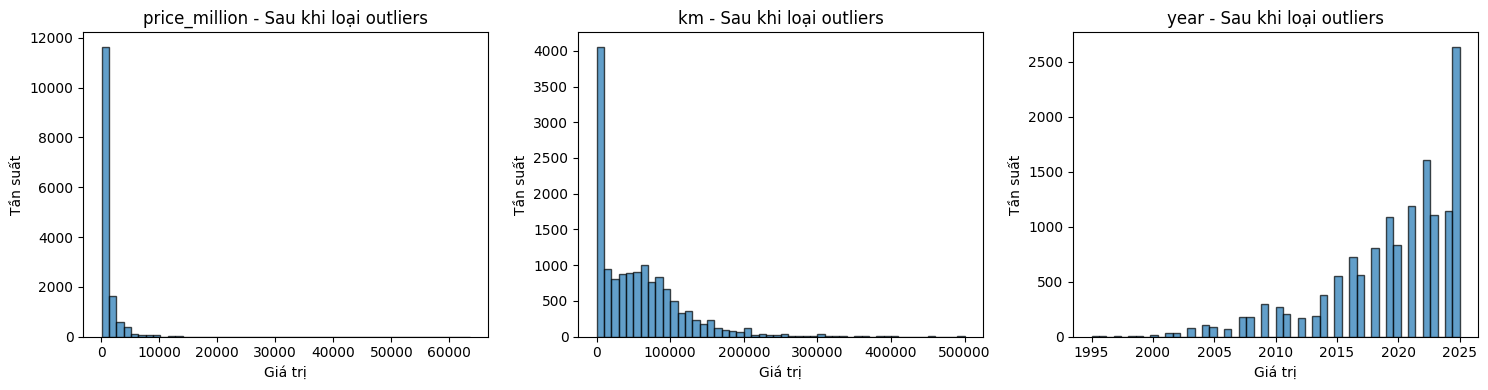

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(numeric_cols):
    axes[i].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col} - Sau khi loại outliers')
    axes[i].set_xlabel('Giá trị')
    axes[i].set_ylabel('Tần suất')

plt.tight_layout()
plt.show()

#### 3.7 Tổng kết Phase III

Cập nhật dataframes gốc với phiên bản đã loại bỏ outliers.

In [43]:
df.reset_index(drop=True, inplace=True)

df.to_csv('../data/interim/outlier_interim.csv', index=False, encoding='utf-8-sig')

print(f"Kích thước cuối cùng: {len(df)} rows")
print(f"  - Chotot: {len(df[df['source'] == 'chotot'])} rows")
print(f"  - BonBanh: {len(df[df['source'] == 'bonbanh'])} rows")
print(f"\nCác cột: {list(df.columns)}")

Kích thước cuối cùng: 14585 rows
  - Chotot: 4601 rows
  - BonBanh: 9984 rows

Các cột: ['price_million', 'km', 'year', 'brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'seats', 'city', 'engine', 'engine_missing', 'source']


### IV. Xử lý Missing Values

Sau khi merge và loại bỏ outliers, tiến hành xử lý missing values trên merged dataset.

#### 4.1 Đánh giá Missing Values hiện tại

In [44]:
missing_stats = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing': missing_stats,
    'Percent': missing_pct
}).sort_values('Missing', ascending=False)

print(missing_df[missing_df['Missing'] > 0])
print(f"\nTổng rows: {len(df)}")

              Missing  Percent
origin           1021     7.00
seats             843     5.78
body_type         736     5.05
km                229     1.57
transmission       16     0.11
year                8     0.05

Tổng rows: 14585


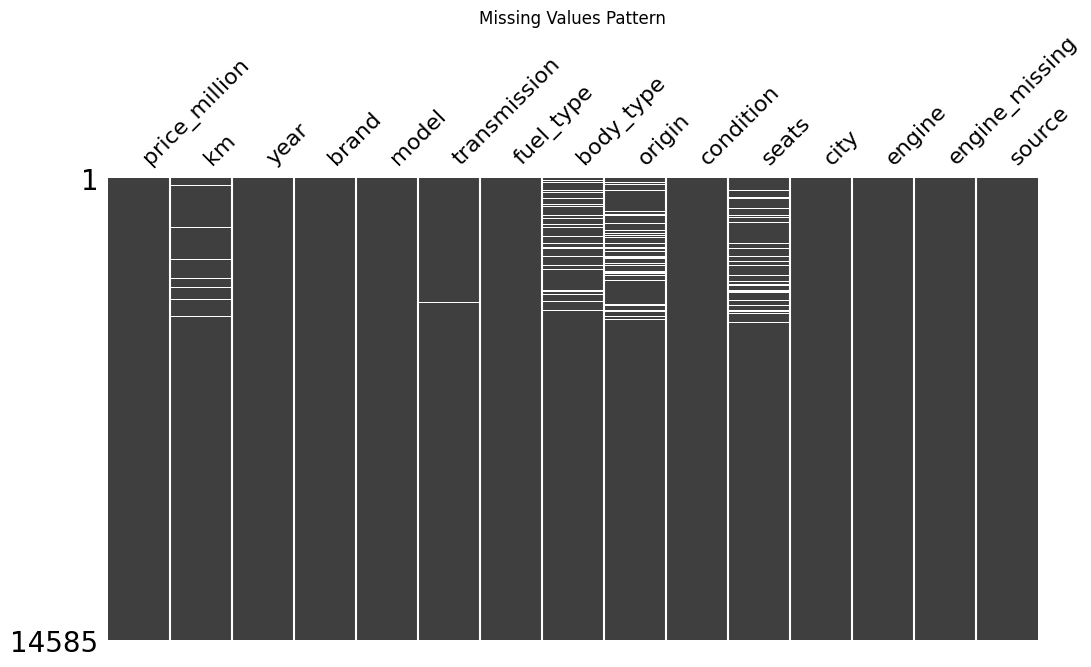

In [45]:
# Visualize missing pattern
msno.matrix(df, figsize=(12, 6), sparkline=False)
plt.title('Missing Values Pattern')
plt.show()

#### 4.2 Chiến lược xử lý Missing Values

| Cột          | Missing | %    | Chiến lược                 | Nguồn dữ liệu                                                                                                                                                 |
|--------------|---------|------|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| origin       | 1021    | 7.00 | Lookup từ brand            | Các hãng có nhà máy lắp ráp tại VN: Toyota, Honda, Mazda, Ford, Hyundai, Kia, Mitsubishi, Suzuki, Isuzu, Thaco, VinFast → "Trong nước", còn lại → "Nhập khẩu" |
| seats        | 843     | 5.78 | Lookup từ body_type        | Bảng quy ước: SUV/MPV/Van → 7 chỗ, Sedan/Hatchback/Crossover → 5 chỗ, Coupe/Convertible → 4 chỗ                                                               |
| body_type    | 736     | 5.05 | Mode theo model            | Tính từ dữ liệu: mỗi model thường chỉ có 1 kiểu thân xe phổ biến nhất                                                                                         |
| km           | 229     | 1.57 | Theo condition             | Xe "Mới" → 0 km, xe "Cũ" → median theo (brand, model, year)                                                                                                   |
| transmission | 16      | 0.11 | Mode theo (brand, model)   | Tính từ dữ liệu: fallback = AT (phổ biến hơn)                                                                                                                 |
| year         | 8       | 0.05 | Median theo (brand, model) | Tính từ dữ liệu: chỉ 8 dòng, dùng median là đủ                                                                                                                |

#### 4.3 Imputation Functions

In [46]:
def impute_by_mode(df, col, group_cols, fallback=None):
    """
    Điền giá trị missing bằng mode của group.
    Trả về DataFrame đã được cập nhật.
    """
    df = df.copy()
    missing_before = df[col].isna().sum()
    
    # Tính mode theo group
    mode_lookup = df.groupby(group_cols)[col].agg(
        lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None
    )
    
    # Tạo dict để lookup nhanh hơn
    mode_dict = mode_lookup.to_dict()
    
    def get_mode(row):
        if pd.isna(row[col]):
            if len(group_cols) > 1:
                key = tuple(row[g] for g in group_cols)
            else:
                key = row[group_cols[0]]
            return mode_dict.get(key, fallback)
        return row[col]
    
    df[col] = df.apply(get_mode, axis=1)
    
    # Fill phần còn lại bằng fallback
    if fallback is not None:
        df[col] = df[col].fillna(fallback)
    
    missing_after = df[col].isna().sum()
    print(f"  {col}: {missing_before} -> {missing_after} missing (đã điền {missing_before - missing_after})")
    
    return df


def impute_by_lookup(df, col, lookup_col, lookup_dict, fallback=None):
    """
    Điền giá trị missing bằng lookup table.
    Trả về DataFrame đã được cập nhật.
    """
    df = df.copy()
    missing_before = df[col].isna().sum()
    
    def get_value(row):
        if pd.isna(row[col]):
            return lookup_dict.get(row[lookup_col], fallback)
        return row[col]
    
    df[col] = df.apply(get_value, axis=1)
    
    if fallback is not None:
        df[col] = df[col].fillna(fallback)
    
    missing_after = df[col].isna().sum()
    print(f"  {col}: {missing_before} -> {missing_after} missing (đã điền {missing_before - missing_after})")
    
    return df


def impute_numeric_by_group(df, col, group_cols, method='median', fallback=None):
    """
    Điền giá trị missing cho cột numeric bằng median/mean của group.
    """
    df = df.copy()
    missing_before = df[col].isna().sum()
    
    # Tính median/mean theo group
    if method == 'median':
        group_stats = df.groupby(group_cols)[col].median()
    else:
        group_stats = df.groupby(group_cols)[col].mean()
    
    group_dict = group_stats.to_dict()
    
    def get_value(row):
        if pd.isna(row[col]):
            if len(group_cols) > 1:
                key = tuple(row[g] for g in group_cols)
            else:
                key = row[group_cols[0]]
            val = group_dict.get(key)
            return val if pd.notna(val) else fallback
        return row[col]
    
    df[col] = df.apply(get_value, axis=1)
    
    if fallback is not None:
        df[col] = df[col].fillna(fallback)
    
    missing_after = df[col].isna().sum()
    print(f"  {col}: {missing_before} -> {missing_after} missing (đã điền {missing_before - missing_after})")
    
    return df

#### 4.4a Impute body_type (mode theo model)

In [47]:
sample_missing = df[df['body_type'].isna()][['brand', 'model', 'body_type']].head(10)
df = impute_by_mode(df, 'body_type', ['model'], fallback='Kiểu dáng khác')
print("\nSample dữ liệu SAU khi impute:")
df.loc[sample_missing.index, ['brand', 'model', 'body_type']]

  body_type: 736 -> 0 missing (đã điền 736)

Sample dữ liệu SAU khi impute:


,brand,model,body_type
11,Daewoo,Matiz,Hatchback
13,Hãng khác,Dòng khác,Kiểu dáng khác
14,Hyundai,Accent,Sedan
17,Mitsubishi,Xpander,SUV
18,Toyota,Innova,Minivan (MPV)
23,Toyota,Vios,Sedan
27,Porsche,Cayenne,SUV
28,Suzuki,Super Carry Van,Kiểu dáng khác
35,Isuzu,Dmax,Pick-up (bán tải)
36,Kia,Rondo,Minivan (MPV)


#### 4.4b Impute seats (lookup từ body_type)

In [48]:
# Định nghĩa bảng lookup seats theo body_type
# Nguồn: quy ước phổ biến trong ngành ô tô Việt Nam
SEATS_LOOKUP = {
    'SUV': 7,              # SUV thường 7 chỗ
    'SUV / Cross over': 7, # SUV/Crossover từ BonBanh
    'Crossover': 5,        # Crossover nhỏ hơn: 5 chỗ
    'Sedan': 5,            # Sedan: 5 chỗ
    'Hatchback': 5,        # Hatchback: 5 chỗ
    'MPV': 7,              # Multi-Purpose Vehicle: 7 chỗ
    'Pickup': 5,           # Bán tải: 5 chỗ
    'Coupe': 4,            # Coupe: 4 chỗ
    'Convertible': 4,      # Mui trần: 4 chỗ
    'Van': 7,              # Van: 7+ chỗ
    'Wagon': 5,            # Wagon: 5 chỗ
    'Minivan': 7,          # Minivan: 7 chỗ
    'Kiểu dáng khác': 5,   # Mặc định: 5 chỗ
    'unknown': 5,          # Mặc định: 5 chỗ
}

In [49]:
sample_missing = df[df['seats'].isna()][['brand', 'model', 'body_type', 'seats']].head(10)
df = impute_by_lookup(df, 'seats', 'body_type', SEATS_LOOKUP, fallback=5)
print("\nSample dữ liệu SAU khi impute (cùng index):")
df.loc[sample_missing.index, ['brand', 'model', 'body_type', 'seats']]

  seats: 843 -> 0 missing (đã điền 843)

Sample dữ liệu SAU khi impute (cùng index):


,brand,model,body_type,seats
13,Hãng khác,Dòng khác,Kiểu dáng khác,5.0
14,Hyundai,Accent,Sedan,5.0
17,Mitsubishi,Xpander,SUV,7.0
23,Toyota,Vios,Sedan,5.0
25,Kia,Morning,Hatchback,5.0
32,Chevrolet,Cruze,Sedan,5.0
35,Isuzu,Dmax,Pick-up (bán tải),5.0
37,Toyota,Vios,Sedan,5.0
39,Kia,Cerato,Sedan,5.0
40,Honda,Civic,Sedan,5.0


#### 4.4c Impute transmission (mode theo brand, model)

In [50]:
sample_missing = df[df['transmission'].isna()][['brand', 'model', 'transmission']].head(10)
df = impute_by_mode(df, 'transmission', ['brand', 'model'], fallback='AT')
print("\nSample dữ liệu SAU khi impute:")
df.loc[sample_missing.index, ['brand', 'model', 'transmission']]

  transmission: 16 -> 0 missing (đã điền 16)

Sample dữ liệu SAU khi impute:


,brand,model,transmission
304,Honda,CR V,AT
311,Mitsubishi,Outlander,AT
831,Mitsubishi,Outlander,AT
922,Honda,CR V,AT
923,Toyota,Corolla Cross,AT
1155,Mitsubishi,Attrage,MT
1537,Kia,Seltos,AT
1633,Mitsubishi,Outlander,AT
1901,Mitsubishi,Attrage,MT
2764,Honda,CR V,AT


#### 4.4d Impute origin (lookup từ brand)

In [51]:
# Định nghĩa danh sách các hãng có nhà máy lắp ráp/sản xuất tại Việt Nam
# Nguồn: thông tin từ các nhà máy ô tô tại VN (Toyota VN, Honda VN, Ford VN, etc.)
VN_BRANDS = [
    'Toyota',      
    'Honda',       
    'Mazda',       
    'Ford',        
    'Hyundai',     
    'Kia',         
    'Mitsubishi', 
    'Suzuki',      
    'Isuzu',       
    'Thaco',       
    'VinFast',     
]

# Tạo lookup dict: hãng VN -> "Trong nước", còn lại -> "Nhập khẩu"
ORIGIN_LOOKUP = {brand: 'Trong nước' for brand in VN_BRANDS}

In [52]:
sample_missing = df[df['origin'].isna()][['brand', 'model', 'origin']].head(10)
df = impute_by_lookup(df, 'origin', 'brand', ORIGIN_LOOKUP, fallback='Nhập khẩu')
print("\nSample dữ liệu SAU khi impute:")
df.loc[sample_missing.index, ['brand', 'model', 'origin']]

  origin: 1021 -> 0 missing (đã điền 1021)

Sample dữ liệu SAU khi impute:


,brand,model,origin
0,BMW,X5,Nhập khẩu
5,LandRover,Range Rover,Nhập khẩu
11,Daewoo,Matiz,Nhập khẩu
25,Kia,Morning,Trong nước
32,Chevrolet,Cruze,Nhập khẩu
39,Kia,Cerato,Trong nước
41,Mazda,6,Trong nước
45,Isuzu,Hi lander,Trong nước
48,Mitsubishi,Lancer,Trong nước
53,Mazda,CX 5,Trong nước


#### 4.4e Impute km (theo condition)

In [53]:
sample_missing = df[df['km'].isna()][['brand', 'model', 'year', 'condition', 'km']].head(10)
# Chiến lược:
# - Xe "Mới" -> km = 0 (xe mới chưa chạy)
# - Xe "Cũ" -> median theo (brand, model, year)

km_missing_before = df['km'].isna().sum()

# Fill xe mới với km = 0
new_car_mask = (df['km'].isna()) & (df['condition'] == 'Mới')
df.loc[new_car_mask, 'km'] = 0
new_filled = new_car_mask.sum()

# Fill xe cũ với median theo (brand, model, year)
overall_km_median = df['km'].median()
km_by_group = df.groupby(['brand', 'model', 'year'])['km'].median().to_dict()

def get_km(row):
    if pd.isna(row['km']):
        key = (row['brand'], row['model'], row['year'])
        val = km_by_group.get(key)
        return val if pd.notna(val) else overall_km_median
    return row['km']

old_car_missing = df['km'].isna().sum()
df['km'] = df.apply(get_km, axis=1)
old_filled = old_car_missing - df['km'].isna().sum()

km_missing_after = df['km'].isna().sum()

print("Sample dữ liệu SAU khi impute (cùng index):")
df.loc[sample_missing.index, ['brand', 'model', 'year', 'condition', 'km']]

Sample dữ liệu SAU khi impute (cùng index):


,brand,model,year,condition,km
9,Ford,Everest,2020.0,Cũ,11040.0
88,Hyundai,Elantra,2017.0,Cũ,80000.0
144,MG,NewMG5,2024.0,Mới,0.0
155,Toyota,Camry,1998.0,Cũ,245188.0
236,MG,HS,2024.0,Mới,0.0
240,Peugeot,5008,2025.0,Mới,0.0
245,Honda,Civic,2018.0,Cũ,67000.0
359,Hyundai,Stargazer,2025.0,Mới,0.0
367,Toyota,Vios,2024.0,Mới,0.0
391,MG,MGZS,2025.0,Mới,0.0


#### 4.4f Impute year (median theo brand, model)

In [54]:
sample_missing = df[df['year'].isna()][['brand', 'model', 'year']].head(10)

year_missing_before = df['year'].isna().sum()
overall_year_median = df['year'].median()
year_by_brand_model = df.groupby(['brand', 'model'])['year'].median().to_dict()

def get_year(row):
    if pd.isna(row['year']):
        key = (row['brand'], row['model'])
        val = year_by_brand_model.get(key)
        return val if pd.notna(val) else overall_year_median
    return row['year']

df['year'] = df.apply(get_year, axis=1)
year_missing_after = df['year'].isna().sum()

print("\nSample dữ liệu SAU khi impute:")
df.loc[sample_missing.index, ['brand', 'model', 'year']]


Sample dữ liệu SAU khi impute:


,brand,model,year
895,Jeep,CJ,2021.0
1458,Hãng khác,Dòng khác,2022.0
1524,Toyota,Corona,2021.0
3566,Jeep,CJ,2021.0
3936,Toyota,Land Cruiser,2025.0
4232,Hãng khác,Dòng khác,2022.0
4298,Hãng khác,Dòng khác,2022.0
7653,Toyota,Land Cruiser BJ70,2021.0


#### 4.5 Validation sau Imputation

In [55]:
missing_after = df.isnull().sum()
cols_with_missing = missing_after[missing_after > 0]

if len(cols_with_missing) == 0:
    print("OK - Không còn missing values!")
else:
    print("Vẫn còn missing values:")
    print(cols_with_missing)

print(f"\nKích thước dataset: {len(df)} rows x {len(df.columns)} cols")
print(f"\nCác cột: {list(df.columns)}")

OK - Không còn missing values!

Kích thước dataset: 14585 rows x 15 cols

Các cột: ['price_million', 'km', 'year', 'brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'seats', 'city', 'engine', 'engine_missing', 'source']


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14585 entries, 0 to 14584
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_million   14585 non-null  float64
 1   km              14585 non-null  float64
 2   year            14585 non-null  float64
 3   brand           14585 non-null  object 
 4   model           14585 non-null  object 
 5   transmission    14585 non-null  object 
 6   fuel_type       14585 non-null  object 
 7   body_type       14585 non-null  object 
 8   origin          14585 non-null  object 
 9   condition       14585 non-null  object 
 10  seats           14585 non-null  float64
 11  city            14585 non-null  object 
 12  engine          14585 non-null  float64
 13  engine_missing  14585 non-null  int64  
 14  source          14585 non-null  object 
dtypes: float64(5), int64(1), object(9)
memory usage: 1.7+ MB


#### 4.6 Tổng kết Phase IV

**Tổng kết Phase IV:**

Dataset sau xử lý missing values: **14,585 rows × 13 cols**

| Cột | Chiến lược | Nguồn dữ liệu |
|-----|------------|---------------|
| body_type | Mode theo model | Tính từ dữ liệu |
| seats | Lookup từ body_type | Bảng SEATS_LOOKUP |
| transmission | Mode theo (brand, model) | Tính từ dữ liệu |
| origin | Lookup từ brand | Danh sách VN_BRANDS |
| km | Xe mới → 0, xe cũ → median | Tính từ dữ liệu |
| year | Median theo (brand, model) | Tính từ dữ liệu |

In [57]:
df.head(10)
df.to_csv('../data/interim/fill_interim.csv', index=False, encoding='utf-8-sig')

### V. Feature Engineering

#### 5.1 Tạo features mới

In [58]:
# age: tuổi xe (năm)
df['age'] = CURRENT_YEAR - df['year']

# km_per_year: số km trung bình mỗi năm
# Xe mới (age=0) → fill = 0
df['km_per_year'] = df.apply(
    lambda row: 0 if row['age'] == 0 else row['km'] / row['age'],
    axis=1
)

# is_luxury: xe sang (1) hay xe phổ thông (0)
LUXURY_BRANDS = [
    'Mercedes Benz', 'BMW', 'Lexus', 'Porsche', 'Jaguar', 'Volvo',
    'Bentley', 'Rolls Royce', 'Maserati', 'Ferrari', 'Lamborghini',
    'Genesis'
]
df['is_luxury'] = df['brand'].isin(LUXURY_BRANDS).astype(int)

df[['brand', 'year', 'age', 'km', 'km_per_year', 'is_luxury']].head(10)

,brand,year,age,km,km_per_year,is_luxury
0,BMW,2007.0,18.0,88000.0,4888.888889,1
1,Mercedes Benz,2001.0,24.0,135000.0,5625.000000,1
2,Ford,2017.0,8.0,275000.0,34375.000000,0
3,Chevrolet,2016.0,9.0,60150.0,6683.333333,0
4,Toyota,2009.0,16.0,15000.0,937.500000,0
5,LandRover,2014.0,11.0,100000.0,9090.909091,0
6,Toyota,2004.0,21.0,56000.0,2666.666667,0
7,Lexus,2010.0,15.0,100000.0,6666.666667,1
8,Isuzu,2019.0,6.0,15000.0,2500.000000,0
9,Ford,2020.0,5.0,11040.0,2208.000000,0


In [59]:
# Kiểm tra phân bố is_luxury
print(f"Số xe sang: {df['is_luxury'].sum()} ({df['is_luxury'].mean()*100:.1f}%)")
print(f"\nThống kê age và km_per_year:")
df[['age', 'km_per_year']].describe()

Số xe sang: 2910 (20.0%)

Thống kê age và km_per_year:


,age,km_per_year
count,14585.000000,14585.000000
mean,5.652520,9969.396844
std,5.439785,12416.038661
min,0.000000,0.000000
25%,1.000000,1.181818
50%,4.000000,8900.000000
75%,8.000000,14000.000000
max,30.000000,470000.000000


### VI. Encoding

Tất cả các cách xử lí bên dưới chỉ đảm bảo khi không có bất kì ô dữ liệu nào là `unknow`

#### 6.1 Tổng quan

In [103]:
THRESHOLD_RATIO = 0.005  # 0.5%

In [60]:
# Xem số lượng unique values của các cột categorical
cat_cols = ['brand', 'model', 'transmission', 'fuel_type', 'body_type', 'origin', 'condition', 'city', 'source']
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

brand: 81 unique values
model: 1363 unique values
transmission: 2 unique values
fuel_type: 4 unique values
body_type: 17 unique values
origin: 2 unique values
condition: 2 unique values
city: 59 unique values
source: 2 unique values


**Chiến lược encoding:**
- **One-hot Encoding:** `transmission`, `fuel_type`, `origin`, `condition`, `source`  (ít categories, không có thứ tự)
- **Group by:** `brand`, `city`, `body_type`(Kiểm tra điều kiện nếu có thể gom nhóm sẽ dùng đucợ one-hot)
- - **Target Encoding:** `model` (nhiều categories)

#### 6.2 One-hot Encoding

Sử dụng cho các feature ít đa dạng, là một tập hữu hạn có số phần tử

In [110]:
def normalize_categorical(x, mapping=None, keywords_map=None):
    """
    x: giá trị cần chuẩn hóa
    mapping: dict {giá trị chuẩn hóa: value mới}, khớp exact
    keywords_map: dict {từ khóa: value mới}, nếu từ khóa xuất hiện trong x -> map
    """
    if pd.isna(x):
        return np.nan

    val = str(x).lower().strip()

    # 1. khớp exact mapping
    if mapping and val in mapping:
        return mapping[val]

    # 2. khớp theo từ khóa
    if keywords_map:
        for kw, kw_val in keywords_map.items():
            if kw in val:
                return kw_val

    # 3. fallback
    return val

##### 6.2.1 Transmission

In [65]:
print(df['transmission'].value_counts())

transmission
AT    12586
MT     1999
Name: count, dtype: int64


In [98]:
df['transmission_binary'] = df['transmission'].str.lower().map({
    'at': 1,
    'mt': 0
})
print(df[['transmission', 'transmission_binary']].head(5))

  transmission  transmission_binary
0           AT                    1
1           AT                    1
2           MT                    0
3           AT                    1
4           AT                    1


##### 6.1.2 Fuel_type

In [69]:
print(df['fuel_type'].value_counts())

fuel_type
Xăng      11110
Dầu        2172
Điện        828
Hybrid      475
Name: count, dtype: int64


In [111]:
# Chuẩn hóa giá trị trước
fuel_mapping = {
    'xăng': 'gasoline',
    'dầu': 'diesel',
    'điện': 'electric',
    'hybrid': 'hybrid'
}
df['fuel_type'] = df['fuel_type'].apply(lambda x: normalize_categorical(x, mapping=fuel_mapping))

# Tạo các cột one-hot
fuel_dummies = pd.get_dummies(df['fuel_type'], prefix='fuel')
df = pd.concat([df, fuel_dummies], axis=1)

# Kiểm tra
print(df[['fuel_type', 'fuel_gasoline', 'fuel_diesel', 'fuel_electric', 'fuel_hybrid']].head(20))

   fuel_type  fuel_gasoline  fuel_gasoline  fuel_gasoline  fuel_diesel  \
0   gasoline           True           True           True        False   
1   gasoline           True           True           True        False   
2     diesel          False          False          False         True   
3   gasoline           True           True           True        False   
4   gasoline           True           True           True        False   
5   gasoline           True           True           True        False   
6   gasoline           True           True           True        False   
7   gasoline           True           True           True        False   
8     diesel          False          False          False         True   
9     diesel          False          False          False         True   
10  gasoline           True           True           True        False   
11  gasoline           True           True           True        False   
12    diesel          False          F

##### 6.1.3 Origin

In [70]:
print(df['origin'].value_counts())

origin
Trong nước    7847
Nhập khẩu     6738
Name: count, dtype: int64


In [72]:
df['inland_binary'] = df['origin'].str.lower().map({
    'trong nước': 1,
    'nhập khẩu': 0
})

print(df[['origin', 'inland_binary']].head(5))

       origin  inland_binary
0   Nhập khẩu              0
1   Nhập khẩu              0
2  Trong nước              1
3   Nhập khẩu              0
4   Nhập khẩu              0


##### 6.1.4 Condition

In [71]:
print(df['condition'].value_counts())

condition
Cũ     12102
Mới     2483
Name: count, dtype: int64


In [73]:
df['new_binary'] = df['condition'].str.lower().map({
    'mới': 1,
    'cũ': 0
})

print(df[['condition', 'new_binary']].head(5))

  condition  new_binary
0        Cũ           0
1        Cũ           0
2        Cũ           0
3        Cũ           0
4        Cũ           0


##### 6.1.5 Source

In [85]:
print(df['source'].value_counts())

source
bonbanh    9984
chotot     4601
Name: count, dtype: int64


In [86]:
df['bobanh_binary'] = df['source'].str.lower().map({
    'bobanh': 1,
    'chotot': 0
})

print(df[['source', 'bobanh_binary']].head(5))

   source  bobanh_binary
0  chotot            0.0
1  chotot            0.0
2  chotot            0.0
3  chotot            0.0
4  chotot            0.0


##### 6.1.6 Body_type

In [74]:
print(df['body_type'].value_counts())

body_type
SUV                      4970
Sedan                    3838
SUV / Cross over         1460
Hatchback                1124
Crossover                 759
Van/Minivan               612
Bán tải / Pickup        560
Minivan (MPV)             509
Pick-up (bán tải)         205
Kiểu dáng khác            195
Van                       162
Coupe                      63
Convertible/Cabriolet      61
Truck                      32
Coupe (2 cửa)              28
Wagon                       4
Mui trần                    3
Name: count, dtype: int64


In [99]:
body_type_mapping = {
    'suv': 'suv',
    'suv / cross over': 'suv',
    'crossover': 'suv',
    'sedan': 'sedan',
    'hatchback': 'hatchback',
    'van/minivan': 'minivan',
    'van': 'minivan',
    'minivan (mpv)': 'minivan',
    'bán tải / pickup': 'pickup',
    'pick-up (bán tải)': 'pickup',
    'coupe': 'coupe',
    'coupe (2 cửa)': 'coupe',
    'convertible/cabriolet': 'convertible',
    'truck': 'truck',
    'wagon': 'wagon',
    'mui trần': 'convertible',
    'kiểu dáng khác': 'other'
}

# Chuẩn hóa body_type
df, dummy_cols = normalize_categorical_threshold(
    df,
    col='body_type',
    mapping=body_type_mapping,
    threshold_ratio=0.05
)

# One-hot encoding
style_dummies = pd.get_dummies(df['body_type'], prefix='body_type')
df = pd.concat([df, style_dummies], axis=1)

# Kiểm tra
print(df[['body_type'] + list(style_dummies.columns)].head(10))


TypeError: normalize_categorical() missing 1 required positional argument: 'col'

#### 6.2 Gom nhóm

Dữ liệu có số lượng nhiều nhưng không quá lớn, có thể dùng được one-hot, gom nhóm lại các dữ liệu dưới ngưỡng để giảm bớt số feature và nhiễu

In [95]:
def normalize_and_group(df, col, threshold_ratio=0.005, other_label='other'):
    """
    Chuẩn hóa tên và gom nhóm các giá trị ít xuất hiện thành 'other'.

    df: DataFrame
    col: tên cột cần xử lý
    threshold_ratio: tỷ lệ tối thiểu (ví dụ 0.005 = 0.5%)
    other_label: nhãn cho các giá trị hiếm
    """
    # 1. Chuẩn hóa tên: lowercase, không dấu, replace space bằng _
    df[col] = df[col].apply(lambda x: unidecode.unidecode(str(x)).lower().replace(' ', '_'))

    # 2. Đếm tần suất
    counts = df[col].value_counts()

    # 3. Xác định threshold
    total_samples = len(df)
    threshold = threshold_ratio * total_samples

    # 4. Gom nhóm các giá trị ít xuất hiện
    df[col] = df[col].apply(lambda x: x if counts[x] >= threshold else other_label)

    # 5. Trả về DataFrame đã xử lý
    return df

#### 6.3 Target Encoding

In [92]:
def kfold_target_encode(train_model, target, test_model=None, n_splits=5, min_samples_leaf=1, smoothing=1, random_state=None):
    """
    train_model: categorical model của train
    target: numeric target model của train
    test_model: categorical model của test (nếu có)
    n_splits: số fold
    min_samples_leaf: minimum samples cho smoothing
    smoothing: hệ số smoothing
    """
    # Global mean
    global_mean = target.mean()

    # KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    train_encoded = pd.Series(index=train_model.index, dtype=float)

    for train_idx, val_idx in kf.split(train_model):
        # Split
        tr, val = train_model.iloc[train_idx], train_model.iloc[val_idx]
        tr_target = target.iloc[train_idx]

        # Compute category mean & count
        averages = tr_target.groupby(tr).agg(['mean', 'count'])

        # Smoothing
        smoothing_factor = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
        averages['te'] = global_mean * (1 - smoothing_factor) + averages['mean'] * smoothing_factor

        # Map to validation fold
        train_encoded.iloc[val_idx] = val.map(averages['te'])

    # Encode test set if given
    if test_model is not None:
        # Compute category mean on full train
        averages_full = target.groupby(train_model).agg(['mean', 'count'])
        smoothing_factor = 1 / (1 + np.exp(-(averages_full['count'] - min_samples_leaf) / smoothing))
        averages_full['te'] = global_mean * (1 - smoothing_factor) + averages_full['mean'] * smoothing_factor

        test_encoded = test_model.map(averages_full['te']).fillna(global_mean)
        return train_encoded, test_encoded

    return train_encoded

In [94]:
# Chuẩn hóa tên model
df['model'] = df['model'].apply(lambda x: unidecode.unidecode(str(x)).lower().replace(' ', '_') if pd.notna(x) else x)

# Kiểm tra số lượng giá trị duy nhất
print(f"Số lượng model duy nhất: {df['model'].nunique()}")
print(f"Top 10 model phổ biến:\n{df['model'].value_counts().head(10)}")

# Áp dụng target encoding cho cột model
# Sử dụng KFold để tránh data leakage
df['model_encoded'] = kfold_target_encode(
    train_model=df['model'],
    target=df['price_million'],
    n_splits=5,
    min_samples_leaf=1,
    smoothing=1,
    random_state=42
)

# Xử lý NaN: fill bằng global mean của price_million
df['model_encoded'] = df['model_encoded'].fillna(df['price_million'].mean())

print(f"\n✓ Đã áp dụng Target Encoding cho cột 'model'")
print(f"Giá trị model_encoded:\n{df['model_encoded'].describe()}")

# Giữ lại cột model gốc để tham khảo, sẽ xóa trước khi train model
print(f"\nDữ liệu mẫu:")
print(df[['model', 'model_encoded', 'price_million']].head(10))

Số lượng model duy nhất: 1361
Top 10 model phổ biến:
model
innova              232
glc_300             182
land_cruiser        180
xpander             178
ranger_xls          171
everest_titanium    160
morning             157
vios                157
dong_khac           144
ranger_wildtrak     140
Name: count, dtype: int64

✓ Đã áp dụng Target Encoding cho cột 'model'
Giá trị model_encoded:
count    14585.000000
mean      1066.422858
std       1294.274166
min         70.268661
25%        435.930071
50%        654.740526
75%       1099.562540
max      15050.307676
Name: model_encoded, dtype: float64

Dữ liệu mẫu:
         model  model_encoded  price_million
0           x5    2525.081048          320.0
1      e_class     845.565217          108.0
2      transit     451.025316          365.0
3        cruze     224.646341          339.0
4        camry     426.573529          380.0
5  range_rover    1099.562540         2450.0
6         zace     132.800005          170.0
7           rx    15

### VI. Lưu Dataset

In [64]:
# Lưu dataset đã xử lý
df.to_csv('../datasets/processed_car_features.csv', index=False)
print(f"Đã lưu dataset: ../datasets/processed_car_features.csv")
print(f"Kích thước: {df.shape[0]} rows x {df.shape[1]} cols")

Đã lưu dataset: ../datasets/processed_car_features.csv
Kích thước: 14585 rows x 27 cols
